<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import ridge_regression
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np
import copy

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (d, d) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (d * n, d)
        n, d = X.shape
        q = compute_q(p)

        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(d)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", n," ", d)
        print("y shape", y.shape)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", d*n)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        #if np.sum(S_mis * S_mis) == 0:
        if np.all(S_dict['S_mis'] == 0):
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        else:  # S_mis.shape == (n, d, d):
          S_dts_tiled = np.concatenate([S_dts] * n)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (d, d):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (d * n, d):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (n, d), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / n * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []

# dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}
def get_path(X, y, estimator, S_dict): #eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
    _, m = X.shape

    if S_dict['algo_superv_learn'] == 'adv':
      #n_a_dts = S_dict['n_a_dts']
      #a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
      #a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']

      if np.all(S_dict['S_dts'] == 0):
        n_a_dts, a_d_dts_max, a_d_dts_min = 1, 0, 0
      else:
        n_a_dts = S_dict['n_a_dts']
        a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
        a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']

      if np.all(S_dict['S_mis'] == 0):
        n_a_mis, a_d_mis_max, a_d_mis_min = 1, 0, 0
      else:
        n_a_mis = S_dict['n_a_mis']
        a_d_mis_max = S_dict['adv_rad_times_delta_mis_max']
        a_d_mis_min = a_d_mis_max * S_dict['eps_adv_rad_times_delta_mis']


      if a_d_dts_max < 0 or a_d_mis_max < 0 or n_a_dts < 1 or n_a_mis <1:
        print("WARNING: some bad values for the grid of cross validation, the number of grid point should be strictly potive, the radius strictly positive")
      alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts) if a_d_dts_max > 0 else np.zeros(1)
      alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis) if a_d_mis_max > 0 else np.zeros(1)
      #alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts)
      #alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis)
      print("dts deltas ", alphas_dts)
      print("mis deltas ", alphas_mis)
      #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
      hyper_p_ret_ = []
      coefs_ = []
      for a_mis_value in tqdm.tqdm(alphas_mis):
        for a_dts_value in tqdm.tqdm(alphas_dts):
            #tuple_key = (scale_dts_value, scale_mis_value)
            #coefs_ = []
            #for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
              #print("dict hyper in get path ", dict_hyper_p_values)
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a_dts_value, a_mis_value])
            #res[tuple_key] = np.stack((coefs_)).T
    elif S_dict['algo_superv_learn'] == 'ridge':
      n_a_rid = S_dict['n_a_rid']
      a_rid_max = S_dict['alpha_ridge_reg_max']
      a_rid_min = a_rid_max * S_dict['eps_alpha_ridge_reg']
      alphas_rid = np.logspace(np.log10(a_rid_min), np.log10(a_rid_max), n_a_rid) if a_rid_max > 0 else np.zeros(1)
      print("rid alphas ", alphas_rid)
      hyper_p_ret_ = []
      coefs_ = []
      print("S_dts_inv in get path, ridge regression \n", S_dict['S_dts'])
      S_dts_inv = np.linalg.inv(S_dict['S_dts'])  # (d, d)
      print("S_dts_inv in get path, ridge regression \n", S_dts_inv)
      for a_rid in tqdm.tqdm(alphas_rid):
            #dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
            #print("dict hyper in get path ", dict_hyper_p_values)
            coefs = estimator(X @ S_dts_inv, y, a_rid)
            coefs = S_dts_inv @ coefs
            #print("alpha  ", a, "coef: ", coefs)
            coefs_.append(coefs if coefs is not None else np.zeros(m))
            hyper_p_ret_.append([a_rid, 0])  #([a_dts_value, a_mis_value])


    '''
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    '''
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

#dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg': 1,
#                             'eps_adv_rad_times_delta_dts': 1e-4, 'eps_adv_rad_times_delta_mis': 1e-4, 'eps_alpha_ridge_reg': 1e-4,
#                             'n_a_dts': 25, 'n_a_mis':4, 'n_a_rid': 25}}





'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):

    if S_dict['algo_superv_learn'] == 'adv':
      linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
      estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
    elif S_dict['algo_superv_learn'] == 'ridge':
      estimator = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False)#, random_state=0)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
      #estimator = lambda X, y, a: linear_model.Ridge(alpha=a).fit(X, y).coef_
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf


X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)

alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=True, random_state=0)
for a in alphas:
  coef, intercept = estim(X, y, a)
  print("coef : ", coef)
  print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  print("coef : ", coef)
  print("intercpt ", intercept)


'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
coef :  [ 2.00570628 -0.99818235 -0.00674327  0.00748903]
intercpt  -0.016602252840644746
coef :  [ 2.00570628 -0.99818235 -0.00674327  0.00748903]
intercpt  -0.016602252840644746
coef :  [ 2.00568936 -0.99817682 -0.00673925  0.00749112]
intercpt  -0.016603636496644494
coef :  [ 2.00568936 -0.99817682 -0.00673925  0.00749112]
intercpt  -0.016603636496644494
coef :  [ 2.00399851 -0.99762466 -0.00633819  0.00769925]
intercpt  -0.01674194936033276
coef :  [ 2.00399851 -0.99762466 -0.00633819  0.00769925]
intercpt  -0.01674194936033276
coef :  [ 1.98879237 -0.99259187 -0.00266045  0.00959587]
intercpt  -0.018014986962789154
coef :  [ 1.98879237 -0.99259187 -0.00266045  0.00959587]
intercpt  -0.018014986962789154
end block


In [3]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  print("X shape in clear data ", X.shape)
  print("y shape in clear data ", y.shape)
  print("M shape in clear data ", M.shape)
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 100000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [4]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
'''
def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks
'''

def generate_masks(dictio_data):#nbr_of_sample, dim, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    dim = len(dictio_data['beta_gt'][0])
    nbr_of_sample = dictio_data['n_train'][-1]  # last one should be the biggest one
    p_missing = dictio_data['p_miss'][0]
    print("p_missing in generate mask ", p_missing)
    if dim == 2:
      if len(p_missing) < 3:
        print("WARNING: p_missing should be a list with a length of 3 if the dimension is 2")
      masks = np.zeros((nbr_of_sample, 2))
      v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
      masks[v == 0, :] = np.array([0, 0])  # both seen
      masks[v == 1, :] = np.array([0, 1])  # left seen
      masks[v == 2, :] = np.array([1, 0])  # right seen
    else:
      # in this branch, p_missing = [p1,.., pl],
      masks = np.array([np.random.binomial(1, 1-pr, (nbr_of_sample, dim)) for pr in p_missing])
      masks = np.cumsum(masks, axis=0)  # each round
      masks[masks>1] = 1
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + -1 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [5]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)  # size (info['mi_nbr], n, d)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:
      if info['cov_strategy'] == 'std_mi':   # std of the imputed dataset, then the mean
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        #s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = std_vectors[:, None, :] * np.eye(std_vectors.shape[-1])  # should be (m, d, d), with each diagonal the diagonals of std_vectors
        #S = s_within
        #S = np.diag(s_within)
        print("final S.shape in cov strategy std_mi ", S.shape)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure'] and 'cov_strategy_between' in info.keys():
      m, n, d = X_imputed.shape
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
        if info['post_imp'] == 'conc':
          S_mis = np.tile(S_mis, (m, 1, 1))
    else:  # not using a mi method, so uncertainty on missing part should be zero
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      print("shape X_imputed ", X_imputed.shape)
      X_train = np.concatenate(X_imputed)
      y_train = np.tile(y_train, X_imputed.shape[0])
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'LogNormal':
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.lognormal(mean=data['mean'], sigma=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim) -0.5
    elif data['data'] == 'Logistic':
      X_complete = np.random.logistic(loc=0.0, scale=1.0, size=(n_tot, dim))
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    elif err['type'] == 'Uniform_on_X':
      error = ((np.random.rand(n_tot, dim)-0.5) @ beta_gt) * err['scaling']
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    # masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    # masks_train = generate_masks_binomial(n_train, p_miss)  # 1 missing, 0 observed
    #X_train, y_train, masks_train = clear_dataset(X_train, y_train, masks_train)
    # M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    # dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, []), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      print("NO PREVIOUS IMPUTATION HAS BEEN DONE")
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      print("A PREVIOUS IMPUTATION HAS BEEN DONE")
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) #* dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  #* dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    if 'post_imp' in dict_obs.keys():
      if dict_obs['post_imp'] == 'conc':
        print(S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing} | dict_obs['info_algo'] | {'algo_superv_learn': dict_imp['algo_superv_learn']}  # , 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    # dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}

    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi' and dict_imp['cov_strategy'] == 'std_mi':  # run a standard multiple imputation procedure
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      min_score = 0
      temporary_dictionary = copy.deepcopy(S_dict)
      for i in range(dict_imp['mi_nbr']):
        print("i  mi .-------------> ", i)
        #dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        #dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        #S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        #S = S_within[None, :, :] + S_between
        #S = np.concatenate(S, axis=0)
        #print(S)
        #alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        temporary_dictionary['S_dts'] = S_dict['S_dts'][i, :, :]
        print("temporary dict ", temporary_dictionary)
        hyper_p_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, temporary_dictionary, [])
        idx_best, min_score_partial = best_idx_predictor(X_test, coeff_results, y_test)
        print("weee ", idx_best)
        print(coeff_results.shape)
        print(hyper_p_used.shape)
        best_coeff_partial, _ = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        min_score += min_score_partial
        #best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
      best_coeff /= dict_imp['mi_nbr']
      min_score /=  dict_imp['mi_nbr']
      best_hyper_p = 0  # not important right now
      best_alpha_delta_dts = 1  # not important right now
      #best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha_delta_dts, best_alpha_delta_mis = best_hyper_p[0], best_hyper_p[1]
#     print("best alpha ----> ", best_alpha_dts)
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = S_dict['S_dts'] * best_alpha_delta_dts + S_dict['S_mis'] * best_alpha_delta_mis
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
    #print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])


    # obsere that one day you shoul add the return of alpha_delta_mis also
    return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)



In [6]:
def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])  # how many trials shall we do
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_hyper_p':[], 'best_alpha_dts':[], 'best_alpha_mis':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed  = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][-1],  # last one should be the biggest
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][-1],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0]
                                             )  # return {'X_train_masked':(X_train, mask_train) , 'X_test':.., 'y_train':, 'y_test'}
      #mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen
      full_masks = generate_masks(dictio)
    dictio_obser_fixed_copy = copy.deepcopy(dictio_obser_fixed)

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        if len(dictio['beta_gt'][0]) == 2:
          #mask_partial = dict_obser_partial['X_train_masked'][1]
          p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
          n_train = full_masks.shape[0]
          mask_partial = full_masks.copy()
          mask_partial[0:int(n_train * p_i), :] = 0
          tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
          dict_obser['X_train_masked'] = tuple_partial
        else:
          #print("size in run experiment", dictio_obser_fixed_copy['X_train_masked'][0].shape, "wee ", dictio_obser_fixed['y_train'].shape)
          ## we use the next line of code with dictio_obser_fixed_copy because we need to test the mask with the original dataset, otherwise we get size error (the dataset change if an observation get fully hidden)
          n_train = dictio['n_train']
          print("n_tot_fll ", n_train, ",  ", n_train[i])
          #print(dictio_obser_fixed_copy['X_train_masked'][0][0:n_train[i], :].shape)
          #print(dictio_obser_fixed_copy['X_train_masked'][0].shape)
          X_train_cleaned, y_train_cleaned, masks_train_cleaned = clear_dataset(dictio_obser_fixed_copy['X_train_masked'][0][0:n_train[i], :], dictio_obser_fixed_copy['y_train'][0:n_train[i]], full_masks[i][0:n_train[i], :])
          print("shapes X_train cleaned, mask train cleaned, y train cleaned")
          print(X_train_cleaned.shape)
          print(masks_train_cleaned.shape)
          print(y_train_cleaned.shape)
          #tuple_partial = (dictio_obser_fixed['X_train_masked'][0], full_masks[i])
          print("full masks in run experiment ", full_masks[i])
          dict_obser['X_train_masked'] = (X_train_cleaned, masks_train_cleaned)
          dict_obser['y_train'] = y_train_cleaned
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      print("info algo in run experiments ", dictio['info_algo'])
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}} | {'info_algo': dictio['info_algo']}  # add an entry for imputed dataset, and info for algorithm
      print("ciaoooooo dict obser in run experiments \n ", dict_obser)
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, hyper_p_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, hyper_p_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_hyper_p'].append(hyper_p_round)  # both hyperparameters
        res[key_tuple]['best_alpha_dts'].append(hyper_p_round[0])  # one of the hyperparameter
        res[key_tuple]['best_alpha_mis'].append(hyper_p_round[1])  # the other hyperparameter

        #res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  lb = extra_info['what_to_plot']
  nbr_plot = len(lb)
  fig_res, ax_res = plt.subplots(1, nbr_plot,
                                 figsize=(35 * (nbr_plot / 3 ), 5))  # , num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key in plot_res", key, ": values\n", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  # lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(nbr_plot):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      print("lb[i] in plot_res ", lb[i], "  ", dictio[lb[i]])
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=20,)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  #ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  #ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[0].set_title(extra_info['title_infer_error'], fontweight='bold', fontsize = 24)
  ax_res[1].set_title(extra_info['title_test_error'], fontweight='bold', fontsize = 24)
  ax_res[2].set_ylabel("-log10(alpha)")
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  #rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  '''
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])
  '''
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      print("res partial \n")
      for k, value in res_partial.items():
        print("key: ", k, " value: ", value)
      plot_res(info_x_axis, res_partial, dictio)
      print("res in run multipl experiments\n")
#      for k, value in res.items():
#        print("key: ", k, " value: ", value)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_hyper_p'].append(res_partial[k]['best_hyper_p'])
        res[k]['best_alpha_dts'].append(res_partial[k]['best_alpha_dts'])
        res[k]['best_alpha_mis'].append(res_partial[k]['best_alpha_mis'])

        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




[-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
change nbr_experiments to match the size of n_train
data :  [{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.44145264,
         0.6412005 ],
       [-3.10308732,  4.38881981, -1.64827646,  1.48837357,  0.6412005 ,
         5.44139855]])}, {'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873

100%|██████████| 1/1 [00:00<00:00, 10.15it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  0.2391640637797849
---------------------------------> best coeff  [-0.07928693  0.70361528 -0.05485394  1.60751087 -1.38862461 -0.33064972]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13834679 0.90622099 1.11601728 1.06694898 1.05734418 0.94257408]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -37.590190504016896
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
S dataset 
 [[1.13834679 0.         0.         0.         0.         0.        ]
 [0.         0.906

100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0143845 0.       ] , min score  1.5068491478235355e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13834679 0.90622099 1.11601728 1.06694898 1.05734418 0.94257408]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -259.82640384685214
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3]
S dataset 
 [[1.28931981 0.         0.         0.         0.         0.        

100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  154  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293  0.07742637] , min score  0.3186030432261179
---------------------------------> best coeff  [-1.10867791e-09  8.50525842e-01 -3.35448017e-07  1.27199408e+00
 -1.74505297e+00 -3.27618268e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13834679 0.90622099 1.11601728 1.06694898 1.05734418 0.94257408]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -259.82640384685214
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3]
S dataset 
 [[1.28931981 0.         0.         0.         0.         0.    

100%|██████████| 1/1 [00:00<00:00,  6.21it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  0.3306084707022885
---------------------------------> best coeff  [-3.34724483e-11  7.83830633e-01 -4.82506419e-10  1.30209512e+00
 -1.75314935e+00 -2.90946912e-01]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, 

100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00127427 0.        ] , min score  0.37182112000285683
---------------------------------> best coeff  [-3.12252544e-01  9.33000409e-01  3.92432744e-09  1.29787929e+00
 -1.50808669e+00 -1.06910467e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.1600166  0.9044291  1.05210511 0.99756895 1.05013789 0.95589244]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -31.194025552173304
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1

100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  1.964583894241234e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.1600166  0.9044291  1.05210511 0.99756895 1.05013789 0.95589244]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -220.49438028517804
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4]
S dataset 
 [[1.24245765 0.         0.   

100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.4888403449627726
---------------------------------> best coeff  [ 0.03453197  0.49751077  0.53006278  1.52180903 -1.56853715 -0.22215099]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.1600166  0.9044291  1.05210511 0.99756895 1.05013789 0.95589244]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -220.49438028517804
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4]
S dataset 
 [[1.24245765 0.         0.         0.         0.         0. 

100%|██████████| 1/1 [00:00<00:00,  6.29it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.4888338540274895
---------------------------------> best coeff  [ 0.03453802  0.4975158   0.53006437  1.52182112 -1.5685438  -0.22215981]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.44145


/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


{'X_train_masked': (array([[-4.66689209e-01,  1.49234837e-02, -1.39007226e+00,
        -4.56385535e-01,  1.37466300e+00,  6.87089132e-01],
       [-1.53519548e-01,  1.86709767e+00,  1.62626667e+00,
        -1.32660949e-01, -8.22202287e-01, -4.25545650e-01],
       [ 2.06590837e+00, -8.02467374e-01, -2.76392444e-01,
         7.27912422e-01,  1.19786733e+00, -2.50613215e+00],
       [ 1.23266331e+00, -6.71671730e-02,  3.50631857e-01,
        -1.22474226e+00, -7.09085618e-01, -1.09887764e+00],
       [ 2.47955084e+00,  8.36345680e-01, -1.51300135e+00,
         5.34005756e-02, -1.13973532e+00, -1.07780785e+00],
       [ 9.92290714e-01, -1.09712157e+00, -2.64730447e+00,
         9.69114029e-01,  4.45367533e-01, -9.76365605e-01],
       [-3.19753608e-01,  1.64007579e-01,  8.26617418e-01,
        -6.55667872e-01,  1.41254068e+00,  1.04256697e-01],
       [-7.22206026e-01, -2.93315259e-01, -2.38621334e-01,
         7.20882256e-01, -3.05472126e-01, -5.24499005e-01],
       [ 4.08749417e-01,  1.

100%|██████████| 1/1 [00:00<00:00,  6.83it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0143845 0.       ] , min score  2.9871576695815065
---------------------------------> best coeff  [-2.71070231e-01  6.54262773e-02  5.78304895e-01  2.48448431e-01
 -1.31414922e+00  8.01233877e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12805098 0.88310295 1.02233088 1.0649292  1.0614936  0.96003406]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.398524254675724
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  1.5911266339701455e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12805098 0.88310295 1.02233088 1.0649292  1.0614936  0.96003406]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -254.50294687081964
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4 1 3 1 3 2 5
 4 2 2 2 2 2 4 1 3 2 2 4]
S d

100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [6.95192796e-04 1.00000000e-05] , min score  0.259166638446769
---------------------------------> best coeff  [ 3.97461134e-06  6.94910030e-01 -9.69705128e-02  1.48959406e+00
 -1.48749385e+00 -3.96214880e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12805098 0.88310295 1.02233088 1.0649292  1.0614936  0.96003406]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -254.50294687081964
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4 1 3 1 3 2 5
 4 2 2 2 2 2 4 1 3 2 

100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  0.25916502775821615
---------------------------------> best coeff  [ 6.83696294e-06  6.94921248e-01 -9.69834016e-02  1.48960602e+00
 -1.48750322e+00 -3.96224120e-01]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, 


/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


(20110, 6)
n_tot_fll  [50, 70, 90, 110, 130] ,   110
X shape in clear data  (110, 6)
y shape in clear data  (110,)
M shape in clear data  (110,)
shapes X_train cleaned, mask train cleaned, y train cleaned
(105, 6)
(105, 6)
(105,)
full masks in run experiment  [[1 1 0 0 0 0]
 [1 0 0 0 1 0]
 [1 1 1 0 0 0]
 [0 0 1 0 0 1]
 [0 0 1 1 1 1]
 [0 1 1 1 0 0]
 [0 0 1 1 0 0]
 [0 1 1 0 1 1]
 [1 1 0 1 1 1]
 [0 0 0 0 1 0]
 [1 0 1 0 1 0]
 [1 0 1 1 1 0]
 [0 0 1 0 0 1]
 [1 0 1 1 0 1]
 [0 0 0 1 0 0]
 [1 0 1 1 1 0]
 [0 1 1 0 0 1]
 [0 0 1 1 1 1]
 [0 1 0 1 1 1]
 [0 1 1 1 1 1]
 [0 1 1 1 0 1]
 [0 0 0 1 1 0]
 [0 0 1 0 0 1]
 [0 1 0 1 0 1]
 [0 1 1 0 0 1]
 [0 1 0 0 0 0]
 [1 0 0 1 0 0]
 [0 1 0 1 0 1]
 [0 1 1 1 0 0]
 [1 1 1 0 1 1]
 [1 1 1 1 1 1]
 [1 0 0 1 1 0]
 [1 0 0 0 0 0]
 [0 1 1 0 1 0]
 [1 0 1 1 0 0]
 [1 0 0 1 0 0]
 [1 0 1 1 1 1]
 [1 0 1 0 1 0]
 [0 0 1 0 1 1]
 [0 1 1 0 0 0]
 [1 0 1 1 0 0]
 [1 0 0 1 0 0]
 [0 1 1 0 1 1]
 [0 1 1 1 0 0]
 [1 1 0 0 1 0]
 [1 0 1 0 0 1]
 [0 0 1 1 0 0]
 [1 1 1 1 0 1]
 [1 0 1 0 0 0]
 [1 0

100%|██████████| 1/1 [00:00<00:00,  6.19it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  0.19061223872409733
---------------------------------> best coeff  [-1.20583618e-01  1.11654440e+00 -1.42635919e-10  1.46994515e+00
 -1.60089715e+00 -3.63581033e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07279917 0.96701723 0.98703018 1.04145369 1.05722576 0.94381175]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.138805276280596
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0

100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  1.8054986089086188e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07279917 0.96701723 0.98703018 1.04145369 1.05722576 0.94381175]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -132.84428675300964
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4 1 3 1 3 2 5
 4 2 2 2 2 2 4 1 3 2 2 4 2 2 

100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  91  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0078476 0.0016681] , min score  0.26605583470154814
---------------------------------> best coeff  [-0.25219788  1.08665698 -0.00284077  1.17096599 -1.55529384 -0.50333047]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07279917 0.96701723 0.98703018 1.04145369 1.05722576 0.94381175]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -132.84428675300964
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4 1 3 1 3 2 5
 4 2 2 2 2 2 4 1 3 2 2 4 2 2 2 1 3 4 2 3 1 3 2 3 2 1 

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0078476 0.       ] , min score  0.2661987889651125
---------------------------------> best coeff  [-0.25284836  1.08846733 -0.00553125  1.17267352 -1.55621457 -0.50516443]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  

100%|██████████| 1/1 [00:00<00:00,  5.34it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  0.1870547671443091
---------------------------------> best coeff  [-1.92602930e-01  1.10380827e+00 -3.69729937e-10  1.43450644e+00
 -1.54210568e+00 -3.35528951e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05032478 0.93620947 1.02752466 1.01262013 1.02729768 0.93513794]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -15.397000789594072
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.

100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16237767 0.        ] , min score  1.080394325830855e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05032478 0.93620947 1.02752466 1.01262013 1.02729768 0.93513794]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -295.4806524124901
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4 1 3 1 3 2 5
 4 2 2 2 2 2 4 1 3 2 2 4 2 2 2

100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.6366509e-02 1.0000000e-05] , min score  0.36996470465542325
---------------------------------> best coeff  [-0.15281323  1.10275836 -0.09305953  1.30902352 -1.42344177 -0.24307831]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05032478 0.93620947 1.02752466 1.01262013 1.02729768 0.93513794]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -295.4806524124901
[2 2 3 2 4 3 2 4 5 1 3 4 2 4 1 4 3 4 4 5 4 2 2 3 3 1 2 3 3 5 3 1 3 3 2 5 3
 3 2 3 2 4 3 3 3 2 5 2 3 0 2 2 2 3 3 3 2 4 2 3 4 4 4 3 3 3 5 4 1 3 1 3 2 5
 4 2 2 2 2 2 4 1 3 2 2 4 2 2 2 1 3 4 2 3 1 3 2

100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02636651 0.        ] , min score  0.3699643123786819
---------------------------------> best coeff  [-0.15281909  1.10276973 -0.09307758  1.30903262 -1.42345105 -0.24308859]
mi
mean
std_nan
5
adv
x_axis for print in plot_res---->  [50, 70, 90, 110, 130]
key in plot_res ('BR_si', 'std_nan', 'adv') : values
 {'best_coeff': [array([-0.07928693,  0.70361528, -0.05485394,  1.60751087, -1.38862461,
       -0.33064972]), array([-3.12252544e-01,  9.33000409e-01,  3.92432744e-09,  1.29787929e+00,
       -1.50808669e+00, -1.06910467e+00]), array([-2.71070231e-01,  6.54262773e-02,  5.78304895e-01,  2.48448431e-01,
       -1.31414922e+00,  8.01233877e-09]), array([-1.20583618e-01,  1.11654440e+00, -1.42635919e-10,  1.46994515e+00,
       -1.60089715e+00, -3.63581033e-01]), array([-1.92602930e-01,  1.10380827e+00, -3.69729937e-10,  1.434

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


(20050, 6)
n_tot_fll  [50, 70, 90, 110, 130] ,   50
X shape in clear data  (50, 6)
y shape in clear data  (50,)
M shape in clear data  (50,)
shapes X_train cleaned, mask train cleaned, y train cleaned
(50, 6)
(50, 6)
(50,)
full masks in run experiment  [[0 1 0 0 0 0]
 [0 1 1 0 0 1]
 [1 1 1 1 1 0]
 [0 1 1 0 0 1]
 [0 0 1 0 0 0]
 [0 0 1 0 1 1]
 [0 1 0 1 0 1]
 [0 0 0 1 0 0]
 [1 1 0 0 0 1]
 [1 0 1 1 0 1]
 [0 1 0 1 0 1]
 [0 1 1 1 0 1]
 [0 1 1 0 0 1]
 [1 0 0 0 1 1]
 [1 0 0 1 0 0]
 [0 0 0 1 0 0]
 [1 1 1 1 1 0]
 [1 1 1 1 1 0]
 [0 1 0 0 1 0]
 [1 1 0 1 1 1]
 [1 0 1 0 0 1]
 [0 1 0 0 0 1]
 [0 0 1 1 0 0]
 [0 0 1 1 1 0]
 [1 0 1 0 0 1]
 [0 1 0 1 1 1]
 [1 1 1 0 1 0]
 [1 0 1 0 0 0]
 [1 1 1 1 0 1]
 [0 1 1 1 1 1]
 [1 1 0 1 1 0]
 [1 0 0 1 0 1]
 [1 1 1 1 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 1 1]
 [1 0 0 0 1 0]
 [1 0 1 0 1 0]
 [1 0 1 1 0 1]
 [0 1 1 1 1 0]
 [0 0 1 1 1 0]
 [0 1 1 1 0 1]
 [0 0 0 1 0 0]
 [1 0 0 0 1 1]
 [0 0 1 0 1 0]
 [0 0 0 0 1 1]
 [1 1 0 1 0 1]
 [1 1 0 1 0 1]
 [0 0 0 1 0 0]
 [1 0 1 1 1 0]
 [1 1 0 1 1 

100%|██████████| 1/1 [00:00<00:00,  7.59it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00127427 0.        ] , min score  3.88970861131149
---------------------------------> best coeff  [-7.42649925e-01  1.26800645e+00 -5.74428850e-08  3.58102732e-01
 -4.28118731e-01  2.51374175e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05079343 0.99552444 1.06823114 1.08284292 0.90620703 0.90698554]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.836316555592738
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.05079343 0.         0.         0.         0.         0. 

100%|██████████| 1/1 [00:00<00:00,  6.09it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  1.15240572457645e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05079343 0.99552444 1.06823114 1.08284292 0.90620703 0.90698554]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -115.1659828803555
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4]
S dataset 
 [[1.20775519 0.         0.         0.         0.         0.       

100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.12772384236359224
---------------------------------> best coeff  [-0.24233121  0.70750869  0.00824518  1.52149522 -1.79408545 -0.5079326 ]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.05079343 0.99552444 1.06823114 1.08284292 0.90620703 0.90698554]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -115.1659828803555
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4]
S dataset 
 [[1.20775519 0.         0.         0.         0.         0.        ]
 [0.         1.13072675 0. 

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.12772265569649208
---------------------------------> best coeff  [-0.24233643  0.7075177   0.00824769  1.52150597 -1.79409893 -0.50794296]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.4414


/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


(20070, 6)
n_tot_fll  [50, 70, 90, 110, 130] ,   70
X shape in clear data  (70, 6)
y shape in clear data  (70,)
M shape in clear data  (70,)
shapes X_train cleaned, mask train cleaned, y train cleaned
(70, 6)
(70, 6)
(70,)
full masks in run experiment  [[0 1 0 0 0 0]
 [0 1 1 0 0 1]
 [1 1 1 1 1 0]
 [0 1 1 0 0 1]
 [0 0 1 0 0 0]
 [0 0 1 0 1 1]
 [0 1 0 1 0 1]
 [0 0 0 1 0 0]
 [1 1 0 0 0 1]
 [1 0 1 1 0 1]
 [0 1 0 1 0 1]
 [0 1 1 1 0 1]
 [0 1 1 0 0 1]
 [1 0 0 0 1 1]
 [1 0 0 1 0 0]
 [0 0 0 1 0 0]
 [1 1 1 1 1 0]
 [1 1 1 1 1 0]
 [0 1 0 0 1 0]
 [1 1 0 1 1 1]
 [1 0 1 0 0 1]
 [0 1 0 0 0 1]
 [0 0 1 1 0 0]
 [0 0 1 1 1 0]
 [1 0 1 0 0 1]
 [0 1 0 1 1 1]
 [1 1 1 0 1 0]
 [1 0 1 0 0 0]
 [1 1 1 1 0 1]
 [0 1 1 1 1 1]
 [1 1 0 1 1 0]
 [1 0 0 1 0 1]
 [1 1 1 1 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 1 1]
 [1 0 0 0 1 0]
 [1 0 1 0 1 0]
 [1 0 1 1 0 1]
 [0 1 1 1 1 0]
 [0 0 1 1 1 0]
 [0 1 1 1 0 1]
 [0 0 0 1 0 0]
 [1 0 0 0 1 1]
 [0 0 1 0 1 0]
 [0 0 0 0 1 1]
 [1 1 0 1 0 1]
 [1 1 0 1 0 1]
 [0 0 0 1 0 0]
 [1 0 1 1 1 0]
 [1 1 0 1 1 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -39.56733742088136
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0]
S dataset 
 [[1.18229769 0.         0.         0.         0.         0.        ]
 [0.         1.08158737 0.         0.         0.         0.        ]
 [0.         0.         0.93327323 0.         0.         0.        ]
 [0.         0.         0.         1.07732378 0.         0.        ]
 [0.         0.         0.         0.         1.0313953  0.        ]
 [0.         0.         0.         0.         0.         0.99254065]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (70, 6)
y_train length  70
-------> size test:  20000  , size 

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.23883736963906063
---------------------------------> best coeff  [-0.41014854  0.96189774 -0.10510705  1.64959173 -1.38702442 -0.29064749]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0171788  1.00212091 1.01069585 1.03890573 1.01268934 0.94328764]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.776363461468588
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.0171788  0.         0.    

100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  1.989842467235606e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0171788  1.00212091 1.01069585 1.03890573 1.01268934 0.94328764]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -165.42027932034074
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0]
S dataset 
 [[1.18229769 0.         0

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.32768291669713473
---------------------------------> best coeff  [-0.42885236  0.84192987  0.01297966  1.23978743 -1.35494952 -0.24892465]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0171788  1.00212091 1.01069585 1.03890573 1.01268934 0.94328764]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -165.42027932034074
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0]
S dataset 
 [[1.18229769 0.         0.         0.         0.       

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.32765370774650127
---------------------------------> best coeff  [-0.42885895  0.84193876  0.01299038  1.23979616 -1.3549696  -0.24894221]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.4414


/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


(20090, 6)
n_tot_fll  [50, 70, 90, 110, 130] ,   90
X shape in clear data  (90, 6)
y shape in clear data  (90,)
M shape in clear data  (90,)
shapes X_train cleaned, mask train cleaned, y train cleaned
(90, 6)
(90, 6)
(90,)
full masks in run experiment  [[0 1 0 0 0 0]
 [0 1 1 0 0 1]
 [1 1 1 1 1 0]
 [0 1 1 0 0 1]
 [0 0 1 0 0 0]
 [0 0 1 0 1 1]
 [0 1 0 1 0 1]
 [0 0 0 1 0 0]
 [1 1 0 0 0 1]
 [1 0 1 1 0 1]
 [0 1 0 1 0 1]
 [0 1 1 1 0 1]
 [0 1 1 0 0 1]
 [1 0 0 0 1 1]
 [1 0 0 1 0 0]
 [0 0 0 1 0 0]
 [1 1 1 1 1 0]
 [1 1 1 1 1 0]
 [0 1 0 0 1 0]
 [1 1 0 1 1 1]
 [1 0 1 0 0 1]
 [0 1 0 0 0 1]
 [0 0 1 1 0 0]
 [0 0 1 1 1 0]
 [1 0 1 0 0 1]
 [0 1 0 1 1 1]
 [1 1 1 0 1 0]
 [1 0 1 0 0 0]
 [1 1 1 1 0 1]
 [0 1 1 1 1 1]
 [1 1 0 1 1 0]
 [1 0 0 1 0 1]
 [1 1 1 1 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 1 1]
 [1 0 0 0 1 0]
 [1 0 1 0 1 0]
 [1 0 1 1 0 1]
 [0 1 1 1 1 0]
 [0 0 1 1 1 0]
 [0 1 1 1 0 1]
 [0 0 0 1 0 0]
 [1 0 0 0 1 1]
 [0 0 1 0 1 0]
 [0 0 0 0 1 1]
 [1 1 0 1 0 1]
 [1 1 0 1 0 1]
 [0 0 0 1 0 0]
 [1 0 1 1 1 0]
 [1 1 0 1 1 

100%|██████████| 1/1 [00:00<00:00,  6.40it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00233572 0.        ] , min score  0.3237186486430938
---------------------------------> best coeff  [-0.32627099  1.17387885 -0.15779265  1.62833192 -1.63743309 -0.27890493]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9598216  1.0243548  1.00371521 1.0011219  0.97915514 0.93159942]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -28.250738477055254
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  2.510750390292211e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9598216  1.0243548  1.00371521 1.0011219  0.97915514 0.93159942]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -112.7009782817322
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 5 3 5 3 

100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.3949959612785244
---------------------------------> best coeff  [-0.31871234  0.79857897  0.17258738  1.16218318 -1.72463557 -0.14466853]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9598216  1.0243548  1.00371521 1.0011219  0.97915514 0.93159942]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -112.7009782817322
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 5 3 5 3 3]
S dataset 
 [[1.06907441 0. 

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.39497821644613157
---------------------------------> best coeff  [-0.31872029  0.79859047  0.17259496  1.16219653 -1.72464913 -0.14467854]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.4414


/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


(20110, 6)
n_tot_fll  [50, 70, 90, 110, 130] ,   110
X shape in clear data  (110, 6)
y shape in clear data  (110,)
M shape in clear data  (110,)
shapes X_train cleaned, mask train cleaned, y train cleaned
(110, 6)
(110, 6)
(110,)
full masks in run experiment  [[0 1 0 0 0 0]
 [0 1 1 0 0 1]
 [1 1 1 1 1 0]
 [0 1 1 0 0 1]
 [0 0 1 0 0 0]
 [0 0 1 0 1 1]
 [0 1 0 1 0 1]
 [0 0 0 1 0 0]
 [1 1 0 0 0 1]
 [1 0 1 1 0 1]
 [0 1 0 1 0 1]
 [0 1 1 1 0 1]
 [0 1 1 0 0 1]
 [1 0 0 0 1 1]
 [1 0 0 1 0 0]
 [0 0 0 1 0 0]
 [1 1 1 1 1 0]
 [1 1 1 1 1 0]
 [0 1 0 0 1 0]
 [1 1 0 1 1 1]
 [1 0 1 0 0 1]
 [0 1 0 0 0 1]
 [0 0 1 1 0 0]
 [0 0 1 1 1 0]
 [1 0 1 0 0 1]
 [0 1 0 1 1 1]
 [1 1 1 0 1 0]
 [1 0 1 0 0 0]
 [1 1 1 1 0 1]
 [0 1 1 1 1 1]
 [1 1 0 1 1 0]
 [1 0 0 1 0 1]
 [1 1 1 1 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 1 1]
 [1 0 0 0 1 0]
 [1 0 1 0 1 0]
 [1 0 1 1 0 1]
 [0 1 1 1 1 0]
 [0 0 1 1 1 0]
 [0 1 1 1 0 1]
 [0 0 0 1 0 0]
 [1 0 0 0 1 1]
 [0 0 1 0 1 0]
 [0 0 0 0 1 1]
 [1 1 0 1 0 1]
 [1 1 0 1 0 1]
 [0 0 0 1 0 0]
 [1 0 1 1 1 0]
 [1 1

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00037927 0.        ] , min score  0.854625029611834
---------------------------------> best coeff  [-0.20858153  0.70542047  0.32802077  0.9029841  -1.39201673 -0.02219037]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97300026 1.02115351 1.04476397 0.96527324 1.05253571 0.98235889]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -57.53284657588253
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16237767 0.        ] , min score  8.393066548695325e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97300026 1.02115351 1.04476397 0.96527324 1.05253571 0.98235889]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -343.401485732669
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 5 3 5 3 

100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.3997178570718037
---------------------------------> best coeff  [-0.41577089  0.96869342  0.10566341  1.3286231  -1.57065959 -0.02859279]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97300026 1.02115351 1.04476397 0.96527324 1.05253571 0.98235889]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -343.401485732669
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 5 3 5 3 3 1 2 1 4 2 1 3 4 2 2 3 1 2 2 3 

100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.3997113169454863
---------------------------------> best coeff  [-0.41578405  0.96869905  0.10567392  1.32863148 -1.57067587 -0.02859672]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.44145

100%|██████████| 1/1 [00:00<00:00,  2.76it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  0.8775704372132772
---------------------------------> best coeff  [-0.23720596  0.47161132  0.23085702  0.92583015 -1.39443523 -0.07832897]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99407135 1.01330369 1.03204939 0.99900391 1.06752797 1.00369684]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -35.748654222952126
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  8.873642379912535e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99407135 1.01330369 1.03204939 0.99900391 1.06752797 1.00369684]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -178.40548446270256
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 5 3 5 3

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.4220142956723479
---------------------------------> best coeff  [-0.61598846  0.56227156  0.19186964  1.33604969 -1.60863042 -0.16692376]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99407135 1.01330369 1.03204939 0.99900391 1.06752797 1.00369684]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -178.40548446270256
[1 3 5 3 1 3 3 1 3 4 3 4 3 3 2 1 5 5 2 5 3 2 2 3 3 4 4 2 5 5 4 3 4 1 3 2 3
 4 4 3 4 1 3 2 2 4 4 1 4 4 4 3 3 2 3 2 2 2 2 2 2 4 3 5 3 4 3 2 2 0 5 3 3 3
 1 2 5 3 4 4 3 4 3 3 3 5 3 5 3 3 1 2 1 4 2 1 3 4 2 2 3 1 2 2 

100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.42200603219295324
---------------------------------> best coeff  [-0.61599979  0.56227906  0.19188108  1.33606023 -1.60864911 -0.16693168]
mi
mean
std_nan
5
adv
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([-7.42649925e-01,  1.26800645e+00, -5.74428850e-08,  3.58102732e-01,
       -4.28118731e-01,  2.51374175e-01]), array([-0.41014854,  0.96189774, -0.10510705,  1.64959173, -1.38702442,
       -0.29064749]), array([-0.32627099,  1.17387885, -0.15779265,  1.62833192, -1.63743309,
       -0.27890493]), array([-0.20858153,  0.70542047,  0.32802077,  0.9029841 , -1.39201673,
       -0.02219037]), array([-0.23720596,  0.47161132,  0.23085702,  0.92583015, -1.39443523,
       -0.07832897])], 'l2_dist_best_coeff_gt': [np.float64(1.968483978480714), np.float64(0.4890931352

100%|██████████| 1/1 [00:00<00:00,  8.14it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  0.6074673606549738
---------------------------------> best coeff  [-0.4520053   0.46707042 -0.00508504  1.20901707 -1.81194965 -0.17210726]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89985394 0.9622149  1.09229422 1.0571102  1.00858426 1.02914558]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  15.191602831037576
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.89985394 0.         0.         0.         0.         0.        ]
 [0.         0.9

100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.184712527473239e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89985394 0.9622149  1.09229422 1.0571102  1.00858426 1.02914558]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  163.93983470078757
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3]
S dataset 
 [[1.01600411 0.         0.         0.         0.         0.      

100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.18620198412128394
---------------------------------> best coeff  [-0.42562444  0.58014581  0.00235895  1.4879622  -1.68171868 -0.45063955]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89985394 0.9622149  1.09229422 1.0571102  1.00858426 1.02914558]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  163.93983470078757
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3]
S dataset 
 [[1.01600411 0.         0.         0.         0.         0.        ]
 [0.         1.04699305 0. 

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.18619315233016343
---------------------------------> best coeff  [-0.42563369  0.58015133  0.00237182  1.48798017 -1.68173342 -0.45064954]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.4414

100%|██████████| 1/1 [00:00<00:00,  5.06it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0143845 0.       ] , min score  0.2030111414671547
---------------------------------> best coeff  [-4.14406064e-01  5.95439072e-01 -2.36776586e-09  1.55378542e+00
 -1.73272776e+00 -3.82867376e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95574298 0.92773818 1.10292513 1.0309204  0.98167211 1.05111877]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.312353594990157
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0

100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  2.99294085188607e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95574298 0.92773818 1.10292513 1.0309204  0.98167211 1.05111877]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  233.27532774687887
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4]
S dataset 
 [[0.97247205 0.         0.   

100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.5433208584605677
---------------------------------> best coeff  [-0.48026788  0.21858226  0.12454065  1.43221113 -1.37986378 -0.50075403]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95574298 0.92773818 1.10292513 1.0309204  0.98167211 1.05111877]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  233.27532774687887
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4]
S dataset 
 [[0.97247205 0.         0.         0.         0.         0.

100%|██████████| 1/1 [00:00<00:00,  5.28it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.5433028558627577
---------------------------------> best coeff  [-0.48028089  0.21858905  0.12455343  1.43223021 -1.37987481 -0.50076343]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.44145

100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0078476 0.       ] , min score  0.13867518233195036
---------------------------------> best coeff  [-3.44535644e-01  8.74773826e-01 -1.53788192e-08  1.58333312e+00
 -1.59016923e+00 -2.72400150e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98386001 0.92355365 1.06511908 0.96101792 0.98860536 1.00855783]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  35.57764440704521
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  3.188139064377758e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98386001 0.92355365 1.06511908 0.96101792 0.98860536 1.00855783]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  398.51380303571034
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4 4 2 5 3 1
 4 1 5 4 4 0 1 2 2 4 4 4 4 4 1]

100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.37595708325776356
---------------------------------> best coeff  [-0.14957529  0.77118562 -0.13587067  1.32287242 -1.47207633 -0.18920792]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98386001 0.92355365 1.06511908 0.96101792 0.98860536 1.00855783]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  398.51380303571034
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4 4 2 5 3 1
 4 1 5 4 4 0 1 2 2 4 4 4 4 4 1]
S dataset 
 [[1.01260662 0.  

100%|██████████| 1/1 [00:00<00:00,  5.15it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.37594427440459627
---------------------------------> best coeff  [-0.14958064  0.77119173 -0.13588402  1.32288983 -1.47209007 -0.18921766]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.4414

100%|██████████| 1/1 [00:00<00:00,  5.01it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0078476 0.       ] , min score  0.3183607449398369
---------------------------------> best coeff  [-0.03324807  0.89747001 -0.19214259  1.49845314 -1.65364079 -0.30296297]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96425155 0.97023776 1.02443731 1.00850864 1.04532824 1.03024025]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  34.82929476202335
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  2.4285293688421065e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96425155 0.97023776 1.02443731 1.00850864 1.04532824 1.03024025]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  378.103172066074
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4 4 2 5 3 1
 4 1 5 4 4 0 1 2 2 4 4 4 4 4 1 4

100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.3775827455752456
---------------------------------> best coeff  [-0.10505436  0.72704798 -0.1869436   1.49236798 -1.46588204 -0.19269224]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96425155 0.97023776 1.02443731 1.00850864 1.04532824 1.03024025]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  378.103172066074
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4 4 2 5 3 1
 4 1 5 4 4 0 1 2 2 4 4 4 4 4 1 4 4 4 2 2 4 2 4 4 3 3 2 4 2 3 2 4

100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.37757226408130184
---------------------------------> best coeff  [-0.10506334  0.72706127 -0.18695603  1.49238325 -1.46589305 -0.19270261]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.4414

100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0143845 0.       ] , min score  0.21161752093383265
---------------------------------> best coeff  [-0.17763101  0.85683646 -0.11120742  1.39713307 -1.68618472 -0.36080447]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9742449  0.97475239 0.99803148 1.03923648 1.00879631 0.99338367]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  27.951423188171127
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16237767 0.        ] , min score  2.0963335559067796e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9742449  0.97475239 0.99803148 1.03923648 1.00879631 0.99338367]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  450.99788880900724
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4 4 2 5 3 1
 4 1 5 4 4 0 1 2 2 4 4 4 4 4 

100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.3879305408100886
---------------------------------> best coeff  [-0.00510274  0.98286459 -0.15675825  1.25002599 -1.63971781 -0.36992555]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.9742449  0.97475239 0.99803148 1.03923648 1.00879631 0.99338367]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  450.99788880900724
[2 5 1 3 3 4 3 2 2 1 0 3 4 3 4 3 4 1 3 2 0 3 3 4 4 2 3 3 1 2 4 4 3 2 3 2 2
 3 5 2 3 1 5 3 3 4 3 4 3 3 4 4 2 3 3 4 4 3 4 4 4 3 3 3 3 4 2 4 4 4 2 5 3 1
 4 1 5 4 4 0 1 2 2 4 4 4 4 4 1 4 4 4 2 2 4 2 4 4 3 3 2 4 2 3 2

100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.3879258344648244
---------------------------------> best coeff  [-0.00510498  0.98287414 -0.15676736  1.25004274 -1.63973208 -0.36993312]
mi
mean
std_nan
5
adv
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([-0.4520053 ,  0.46707042, -0.00508504,  1.20901707, -1.81194965,
       -0.17210726]), array([-4.14406064e-01,  5.95439072e-01, -2.36776586e-09,  1.55378542e+00,
       -1.73272776e+00, -3.82867376e-01]), array([-3.44535644e-01,  8.74773826e-01, -1.53788192e-08,  1.58333312e+00,
       -1.59016923e+00, -2.72400150e-01]), array([-0.03324807,  0.89747001, -0.19214259,  1.49845314, -1.65364079,
       -0.30296297]), array([-0.17763101,  0.85683646, -0.11120742,  1.39713307, -1.68618472,
       -0.36080447])], 'l2_dist_best_coeff_gt': [np.float64(0.770589593329159), 

100%|██████████| 1/1 [00:00<00:00,  7.32it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  2.2796561942420843
---------------------------------> best coeff  [ 5.20273075e-01  6.92106113e-01  2.86867928e-10  5.82067765e-01
 -8.76110712e-01 -2.98814411e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.86451509 1.00075334 0.92758039 1.2547733  1.07845931 0.98214631]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.483372543878893
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.86451509 0.         0.         0.         0.         0. 

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  7.959558817908897e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.86451509 1.00075334 0.92758039 1.2547733  1.07845931 0.98214631]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -279.035718751976
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5]
S dataset 
 [[0.73558314 0.         0.         0.         0.         0.        

100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.83293024e-02 1.00000000e-05] , min score  1.0669959886095974
---------------------------------> best coeff  [ 0.20186464  0.69119879 -0.03342045  1.24165063 -0.91259369 -1.00978904]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.86451509 1.00075334 0.92758039 1.2547733  1.07845931 0.98214631]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -279.035718751976
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5]
S dataset 
 [[0.73558314 0.         0.         0.         0.         0.        ]
 [0.        

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  1.0669747502368832
---------------------------------> best coeff  [ 0.20188478  0.69122276 -0.0334249   1.2416656  -0.91262816 -1.00981202]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00037927 0.        ] , min score  0.5735274325734854
---------------------------------> best coeff  [-0.53098899  0.5574606   0.53891889  1.13757713 -1.2621622  -0.42264613]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.87811293 0.97059748 0.94598345 1.21487631 1.0247927  0.99440358]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.758325713504165
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.87811293 0.         

100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  1.020407481431109e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.87811293 0.97059748 0.94598345 1.21487631 1.0247927  0.99440358]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -181.15892549423347
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4]
S dataset 
 [[0.83504733 0.         0

100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.09694790071440804
---------------------------------> best coeff  [-0.40979402  0.73526668  0.31729428  1.40805701 -1.55439502 -0.73347453]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.87811293 0.97059748 0.94598345 1.21487631 1.0247927  0.99440358]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -181.15892549423347
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4]
S dataset 
 [[0.83504733 0.         0.         0.         0.       

100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.09694624326194119
---------------------------------> best coeff  [-0.40981172  0.73528984  0.31732325  1.40808062 -1.55441413 -0.7334837 ]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.4414

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -27.65223474013017
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0 1]
S dataset 
 [[0.86269929 0.         0.         0.         0.         0.        ]
 [0.         0.8737     0.         0.         0.         0.        ]
 [0.         0.         0.99769357 0.         0.         0.        ]
 [0.         0.         0.         1.20403536 0.         0.        ]
 [0.         0.         0.         0.         0.99493092 0.        ]
 [0.         0.         0.         0.         0.         1.02277914]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (90, 6)
y_train lengt

100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  1.5170064291102834
---------------------------------> best coeff  [-0.00779586  0.3640603   0.77226559  1.03990367 -0.93981354 -0.14824359]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89788474 0.99816375 0.91087425 1.21443016 0.972211   1.04350699]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -20.41930834870612
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  1.0298160670354872e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89788474 0.99816375 0.91087425 1.21443016 0.972211   1.04350699]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -183.51958931671612
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 

100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.6230760889537791
---------------------------------> best coeff  [ 0.02171818  0.46608464 -0.0848395   1.24754488 -1.15862202 -0.60964806]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89788474 0.99816375 0.91087425 1.21443016 0.972211   1.04350699]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -183.51958931671612
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0 1]
S dataset 
 [[0.86269929 0.

100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.6230506682307868
---------------------------------> best coeff  [ 0.0217223   0.46609973 -0.08484434  1.24755611 -1.15863675 -0.60965649]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.44145

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -32.739848810257335
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0 1 3 4 4 2 2 3 4 4 1 3 4 4 4 4 3 2 2 3 3 4]
S dataset 
 [[0.91394744 0.         0.         0.         0.         0.        ]
 [0.         0.87125899 0.         0.         0.         0.        ]
 [0.         0.         1.08469893 0.         0.         0.        ]
 [0.         0.         0.         1.19207543 0.         0.        ]
 [0.         0.         0.         0.         1.00858413 0.        ]
 [0.         0.         0.         0.         0.         0.98456644]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed 

100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16237767 0.        ] , min score  2.613474061245011
---------------------------------> best coeff  [-8.89580655e-12  7.60817832e-12  3.16649204e-01  8.89138288e-01
 -5.72167052e-01 -2.31194246e-02]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92940832 0.97058336 0.96761176 1.21187519 1.00615041 1.0252634 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -19.070697874315584
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  6.886894186142324e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92940832 0.97058336 0.96761176 1.21187519 1.00615041 1.0252634 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -147.64276346398543
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.6741125054346205
---------------------------------> best coeff  [-0.14040281  0.41131906  0.04141373  1.44556248 -1.03280409 -0.90373819]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92940832 0.97058336 0.96761176 1.21187519 1.00615041 1.0252634 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -147.64276346398543
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0 1 3 4 4 2 2 3 4 4 1 3 4 4 4 4 

100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.6740804140703549
---------------------------------> best coeff  [-0.14041007  0.41133725  0.04142299  1.44557656 -1.03281817 -0.90375116]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.44145

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -25.736855839741935
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0 1 3 4 4 2 2 3 4 4 1 3 4 4 4 4 3 2 2 3 3 4 2
 4 2 2 3 3 3 2 3 5 5 0 2 4 5 5 3 3 1]
S dataset 
 [[0.94017071 0.         0.         0.         0.         0.        ]
 [0.         0.926373   0.         0.         0.         0.        ]
 [0.         0.         1.04595798 0.         0.         0.        ]
 [0.         0.         0.         1.29987595 0.         0.        ]
 [0.         0.         0.         0.         1.00869136 0.        ]
 [0.         0.         0.         0.         0.         0.9829507 ]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]

100%|██████████| 1/1 [00:00<00:00,  3.57it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  1.5781925602277163
---------------------------------> best coeff  [-0.2981118   0.08016212  0.54942553  1.12985901 -0.77925033 -0.44970951]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92756376 0.98158054 0.95274443 1.24585037 1.0069255  0.99563326]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -35.52702060652128
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  6.525195539705361e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92756376 0.98158054 0.95274443 1.24585037 1.0069255  0.99563326]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -365.4756968190653
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0 

100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.43844989e-02 1.00000000e-05] , min score  0.1886911376069976
---------------------------------> best coeff  [-0.23499981  0.82479595 -0.02033065  1.41080363 -1.31607986 -0.77556305]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92756376 0.98158054 0.95274443 1.24585037 1.0069255  0.99563326]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -365.4756968190653
[1 4 4 4 5 1 4 3 5 2 3 2 3 2 1 3 5 5 2 3 4 3 4 2 4 3 4 5 3 4 5 5 3 3 2 3 3
 3 2 2 1 1 1 5 2 5 1 2 3 5 4 3 5 3 2 3 2 3 3 3 0 3 4 1 1 3 2 3 2 4 5 5 3 2
 2 3 2 2 2 4 3 5 4 1 5 1 3 2 0 1 3 4 4 2 2 3 

100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0143845 0.       ] , min score  0.18868223264905656
---------------------------------> best coeff  [-0.23500783  0.82481003 -0.0203359   1.4108135  -1.31609703 -0.77557022]
mi
mean
std_nan
5
adv
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([ 5.20273075e-01,  6.92106113e-01,  2.86867928e-10,  5.82067765e-01,
       -8.76110712e-01, -2.98814411e-01]), array([-0.53098899,  0.5574606 ,  0.53891889,  1.13757713, -1.2621622 ,
       -0.42264613]), array([-0.00779586,  0.3640603 ,  0.77226559,  1.03990367, -0.93981354,
       -0.14824359]), array([-8.89580655e-12,  7.60817832e-12,  3.16649204e-01,  8.89138288e-01,
       -5.72167052e-01, -2.31194246e-02]), array([-0.2981118 ,  0.08016212,  0.54942553,  1.12985901, -0.77925033,
       -0.44970951])], 'l2_dist_best_coeff_gt': [np.float64(1.5137640888

100%|██████████| 1/1 [00:00<00:00,  7.06it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02636651 0.        ] , min score  3.5246186749556245
---------------------------------> best coeff  [-3.87131886e-01  5.89073212e-01  6.22606708e-01 -3.18661523e-09
 -8.43033485e-01 -1.42915491e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90012512 0.86475719 1.15492321 0.9244648  1.00163915 0.97052361]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  0.44327620281765556
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.90012512 0.         0.         0.         0.         0.        ]
 

100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00233572 0.        ] , min score  4.761465786871704e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90012512 0.86475719 1.15492321 0.9244648  1.00163915 0.97052361]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.64914063751933
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5]
S dataset 
 [[0.93051825 0.         0.         0.         0.         0.        ]
 [0.  

100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [8.8586679e-02 1.0000000e-05] , min score  2.235060799915708
---------------------------------> best coeff  [-0.29886442  1.00572925  0.07904054  0.29855756 -1.00991535 -0.09680326]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90012512 0.86475719 1.15492321 0.9244648  1.00163915 0.97052361]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.64914063751933
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5]
S dataset 
 [[0.93051825 0.         0.         0.         0.         0.        ]
 [0.         0.78942661

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.2350231355744263
---------------------------------> best coeff  [-0.2988888   1.0057933   0.07901442  0.29855897 -1.00995696 -0.0968133 ]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  1.364425512146203
---------------------------------> best coeff  [-0.30687525  1.05928094 -0.29103653  0.81026514 -1.20080753  0.0168819 ]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93365711 0.93468086 1.10405758 0.95294982 0.97102019 0.91575848]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  9.982952598383978
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.93365711 0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00233572 0.        ] , min score  3.8525321500344915e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93365711 0.93468086 1.10405758 0.95294982 0.97102019 0.91575848]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  60.43373467661534
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5]
S dataset 
 [[0.88895906 0.         0.        

100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  1.109762654530683
---------------------------------> best coeff  [-0.51619612  1.32140714  0.08132873  0.80261801 -1.16813602 -0.30120263]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93365711 0.93468086 1.10405758 0.95294982 0.97102019 0.91575848]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  60.43373467661534
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5]
S dataset 
 [[0.88895906 0.         0.         0.         0.         0.        

100%|██████████| 1/1 [00:00<00:00,  5.15it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  1.1097467419392195
---------------------------------> best coeff  [-0.51619638  1.32142615  0.08132671  0.80262943 -1.16814697 -0.30121468]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.44145

100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  1.361713158027209
---------------------------------> best coeff  [-9.51534248e-02  7.44687967e-01 -7.19101967e-11  8.19444193e-01
 -9.84212076e-01  2.53195873e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98431773 0.95578851 1.07672894 0.95792055 0.94255573 0.88475995]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -0.9820499102733269
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00233572 0.        ] , min score  4.5549867815153025e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98431773 0.95578851 1.07672894 0.95792055 0.94255573 0.88475995]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  76.45749280443223
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 1]
S dat

100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  1.152027727640164
---------------------------------> best coeff  [-0.43631488  1.02865419  0.18406893  0.73466285 -1.10587439 -0.16529608]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98431773 0.95578851 1.07672894 0.95792055 0.94255573 0.88475995]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  76.45749280443223
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 1]
S dataset 
 [[1.00201428 0.         0.

100%|██████████| 1/1 [00:00<00:00,  4.37it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  1.151998217280957
---------------------------------> best coeff  [-0.43631678  1.02866595  0.18407019  0.73467152 -1.10588427 -0.16530746]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.441452

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


dts deltas  [1.00000000e-05 1.83298071e-05 3.35981829e-05 6.15848211e-05
 1.12883789e-04 2.06913808e-04 3.79269019e-04 6.95192796e-04
 1.27427499e-03 2.33572147e-03 4.28133240e-03 7.84759970e-03
 1.43844989e-02 2.63665090e-02 4.83293024e-02 8.85866790e-02
 1.62377674e-01 2.97635144e-01 5.45559478e-01 1.00000000e+00]
mis deltas  [0.]


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02636651 0.        ] , min score  1.359346107732002
---------------------------------> best coeff  [-0.60949045  1.01764548 -0.51443535  1.05060194 -1.01302511 -0.21352851]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96607711 0.98344816 1.03783163 0.94118695 1.04221136 0.89822557]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  6.010999088633531
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  2.5045575802829062e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96607711 0.98344816 1.03783163 0.94118695 1.04221136 0.89822557]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -30.14432182930303
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 1 4 3 0

100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.6252516950577391
---------------------------------> best coeff  [-0.35190697  0.89271453 -0.07727564  1.01911733 -1.2468597  -0.23138091]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96607711 0.98344816 1.03783163 0.94118695 1.04221136 0.89822557]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -30.14432182930303
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 1 4 3 0 3 4 1 4 3 5 3 5 3 1 2 2 4 5 3 4

100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.6252204998119377
---------------------------------> best coeff  [-0.35191508  0.89272595 -0.07730312  1.01914446 -1.24687169 -0.23139439]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.44145

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  21.832217918787823
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 1 4 3 0 3 4 1 4 3 5 3 5 3 1 2 2 4 5 3 4 2 4 2 1 3 2
 1 5 4 5 0 5 2 2 2 3 2 4 4 3 4]
S dataset 
 [[0.96062039 0.         0.         0.         0.         0.        ]
 [0.         0.88411428 0.         0.         0.         0.        ]
 [0.         0.         1.00197116 0.         0.         0.        ]
 [0.         0.         0.         0.95680823 0.         0.        ]
 [0.         0.         0.         0.         1.01789965 0.        ]
 [0.         0.         0.         0.         0.         0.96165326]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0

100%|██████████| 1/1 [00:00<00:00,  3.16it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0143845 0.       ] , min score  1.6309494155193216
---------------------------------> best coeff  [-0.76738181  1.13684703 -0.50658105  0.99520106 -1.07499413 -0.07757485]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97771801 0.94905888 1.02078553 0.95640825 1.03278977 0.94018681]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  16.37890190921424
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  2.5387300648600058e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97771801 0.94905888 1.02078553 0.95640825 1.03278977 0.94018681]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  77.93606801071249
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 1 4 3 0 

100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.7966269508414267
---------------------------------> best coeff  [-0.59656738  1.00868163 -0.15596669  1.14236961 -1.13911505 -0.15282525]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97771801 0.94905888 1.02078553 0.95640825 1.03278977 0.94018681]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  77.93606801071249
[4 2 4 2 2 5 4 4 3 2 4 3 2 4 2 5 5 2 2 4 3 3 4 3 3 3 2 3 2 2 3 4 4 2 3 4 3
 2 2 4 3 2 2 2 1 5 3 3 2 3 2 3 2 4 3 5 2 4 5 3 5 3 2 2 4 5 5 1 3 4 1 3 2 2
 2 3 4 3 1 1 3 2 4 3 1 1 4 3 0 3 4 1 4 3 5 3 5 3 1 2 2 4 5 3 4 

100%|██████████| 1/1 [00:00<00:00,  3.24it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.7966162779556081
---------------------------------> best coeff  [-0.59658243  1.00869812 -0.15599059  1.14239208 -1.13912958 -0.15283532]
mi
mean
std_nan
5
adv
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([-3.87131886e-01,  5.89073212e-01,  6.22606708e-01, -3.18661523e-09,
       -8.43033485e-01, -1.42915491e-01]), array([-0.30687525,  1.05928094, -0.29103653,  0.81026514, -1.20080753,
        0.0168819 ]), array([-9.51534248e-02,  7.44687967e-01, -7.19101967e-11,  8.19444193e-01,
       -9.84212076e-01,  2.53195873e-10]), array([-0.60949045,  1.01764548, -0.51443535,  1.05060194, -1.01302511,
       -0.21352851]), array([-0.76738181,  1.13684703, -0.50658105,  0.99520106, -1.07499413,
       -0.07757485])], 'l2_dist_best_coeff_gt': [np.float64(1.861632222154966), 

100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  0.37581020725843484
---------------------------------> best coeff  [-0.0788851   0.66554372 -0.0771184   1.22294993 -1.289793   -0.5314007 ]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12163434 1.0548881  1.03380533 1.03549982 0.99494165 1.00718827]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -20.61421829073916
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
S dataset 
 [[1.12163434 0.         0.         0.         0.         0.        ]
 [0.         1.054

100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  8.356496598886332e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12163434 1.0548881  1.03380533 1.03549982 0.99494165 1.00718827]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1.6501756863910035
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2]
S dataset 
 [[1.0687597  0.         0.         0.         0.         0.        

100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.83293024e-02 1.00000000e-05] , min score  0.26690009065180537
---------------------------------> best coeff  [-1.46720035e-10  8.75080990e-01 -8.19158372e-02  1.29221197e+00
 -1.54241704e+00 -4.76613213e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12163434 1.0548881  1.03380533 1.03549982 0.99494165 1.00718827]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1.6501756863910035
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2]
S dataset 
 [[1.0687597  0.         0.         0.         0.        

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  0.26689258542392436
---------------------------------> best coeff  [ 2.05002391e-11  8.75090532e-01 -8.19209877e-02  1.29222625e+00
 -1.54242718e+00 -4.76623966e-01]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -


/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


(20070, 6)
n_tot_fll  [50, 70, 90, 110, 130] ,   70
X shape in clear data  (70, 6)
y shape in clear data  (70,)
M shape in clear data  (70,)
shapes X_train cleaned, mask train cleaned, y train cleaned
(69, 6)
(69, 6)
(69,)
full masks in run experiment  [[0 1 1 1 1 0]
 [0 1 1 1 0 0]
 [0 0 0 1 1 0]
 [1 0 0 0 1 1]
 [0 0 1 0 1 0]
 [1 1 1 0 0 0]
 [0 0 1 0 0 1]
 [0 1 1 1 0 0]
 [0 0 0 1 0 0]
 [0 0 1 1 0 1]
 [0 1 1 1 1 0]
 [0 0 1 0 1 0]
 [1 1 1 0 0 0]
 [1 1 1 1 0 1]
 [0 0 1 1 0 1]
 [0 0 0 0 0 1]
 [1 0 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 1 0 0]
 [0 0 1 1 0 1]
 [0 0 1 1 1 1]
 [1 0 0 1 1 1]
 [1 1 0 1 1 1]
 [1 1 0 1 1 0]
 [0 0 1 1 0 0]
 [1 0 0 1 0 1]
 [1 1 1 0 0 0]
 [1 0 0 1 1 0]
 [1 0 0 0 0 1]
 [1 0 0 1 1 0]
 [0 0 1 0 1 1]
 [1 1 1 1 1 1]
 [1 0 0 0 1 0]
 [0 0 1 0 0 0]
 [0 0 1 1 0 0]
 [0 1 1 1 0 1]
 [0 0 0 0 1 1]
 [1 0 0 0 0 0]
 [1 1 1 0 0 1]
 [1 0 0 0 1 0]
 [0 0 0 1 1 0]
 [0 0 0 1 1 1]
 [1 0 0 0 0 0]
 [1 0 0 1 1 0]
 [0 0 1 0 1 1]
 [1 1 0 0 1 0]
 [0 1 1 1 1 0]
 [1 0 0 1 0 0]
 [0 0 1 1 0 1]
 [0 0 1 1 0 

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  0.2796020501758271
---------------------------------> best coeff  [-3.38527879e-01  5.65304434e-01  9.10992485e-10  1.25943946e+00
 -1.41601670e+00 -7.02490211e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11468897 1.07894618 1.04188477 0.96140896 0.97444686 1.03466972]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -15.992852283140923
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[

100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  1.855560002440563e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11468897 1.07894618 1.04188477 0.96140896 0.97444686 1.03466972]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  40.03917137937607
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5]
S dataset 
 [[1.08368712 0.         0.   

100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [7.8475997e-03 1.0000000e-05] , min score  0.5027660298724221
---------------------------------> best coeff  [-0.17973087  0.72734652 -0.25957745  1.21340046 -1.29141297 -0.77987009]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.11468897 1.07894618 1.04188477 0.96140896 0.97444686 1.03466972]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  40.03917137937607
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5]
S dataset 
 [[1.08368712 0.         0.         0.        

100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0078476 0.       ] , min score  0.5027575900025738
---------------------------------> best coeff  [-0.17973538  0.72735773 -0.25958861  1.21341834 -1.29142268 -0.77987938]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  75.51188509781625
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1 5 4 4]
S dataset 
 [[1.06358231 0.         0.         0.         0.         0.        ]
 [0.         1.01639916 0.         0.         0.         0.        ]
 [0.         0.         1.15644208 0.         0.         0.        ]
 [0.         0.         0.         1.02834976 0.         0.        ]
 [0.         0.         0.         0.         0.88657971 0.        ]
 [0.         0.         0.         0.         0.         0.7862385 ]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (88, 6)
y_train length  88

100%|██████████| 1/1 [00:00<00:00,  4.97it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02636651 0.        ] , min score  0.6445554945634115
---------------------------------> best coeff  [-0.42299952  0.35927682  0.1222978   1.04711156 -1.56113503 -0.8593106 ]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07227196 1.04521354 1.07738135 0.94579548 0.91251244 1.00646718]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.592089721762731
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  2.1778224363106313e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07227196 1.04521354 1.07738135 0.94579548 0.91251244 1.00646718]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  198.95681484580555
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1 5 4 4]


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.3384792096254615
---------------------------------> best coeff  [-0.27061042  0.79197267  0.15505043  1.02695706 -1.50462281 -0.73754527]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07227196 1.04521354 1.07738135 0.94579548 0.91251244 1.00646718]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  198.95681484580555
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1 5 4 4]
S dataset 
 [[1.06358231 0.     

100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.33846698882088405
---------------------------------> best coeff  [-0.27061912  0.79198139  0.15506451  1.02696941 -1.50463761 -0.73756678]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.4414

100%|██████████| 1/1 [00:00<00:00,  4.28it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0078476 0.       ] , min score  0.14709805862389225
---------------------------------> best coeff  [-0.36802925  0.80615529 -0.12831177  1.46398508 -1.5216154  -0.48148167]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07385112 1.03935859 1.0397922  0.94859985 0.95259377 1.07822312]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -13.138460541959898
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  1.7865676497773576e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07385112 1.03935859 1.0397922  0.94859985 0.95259377 1.07822312]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.5088858929407465
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1 5 4 4 

100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.24627176492930752
---------------------------------> best coeff  [-0.35093523  0.62792464  0.04952908  1.20499164 -1.47824635 -0.46807345]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07385112 1.03935859 1.0397922  0.94859985 0.95259377 1.07822312]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.5088858929407465
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1 5 4 4 1 2 2 3 3 2 3 3 4 2 5 2 4 3 4 3

100%|██████████| 1/1 [00:00<00:00,  4.17it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.24625246503896056
---------------------------------> best coeff  [-0.35093882  0.62793313  0.04953969  1.20500122 -1.47826222 -0.46808416]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.4414

100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0143845 0.       ] , min score  0.07476026541842153
---------------------------------> best coeff  [-0.35103045  0.80081476 -0.01765473  1.52484783 -1.53902449 -0.46564729]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.04492721 1.0404552  1.02252359 0.97396198 0.91042185 1.06319954]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -23.219437667758285
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  1.8717560872743742e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.04492721 1.0404552  1.02252359 0.97396198 0.91042185 1.06319954]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -66.85623533747463
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1 5 4 4 1

100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.3010702007350473
---------------------------------> best coeff  [-0.26234038  0.57006136 -0.05570485  1.28307988 -1.34009777 -0.55365196]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.04492721 1.0404552  1.02252359 0.97396198 0.91042185 1.06319954]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -66.85623533747463
[4 3 2 3 2 3 2 3 1 3 4 2 3 5 3 1 5 4 1 3 4 4 5 4 2 3 3 3 2 3 3 2 1 2 4 2 1
 4 2 2 3 1 3 3 3 4 2 3 2 3 5 3 2 2 2 2 2 5 2 3 3 3 4 3 2 3 4 3 5 2 3 1 2 4
 2 2 3 3 4 2 3 1 4 2 1 5 4 4 1 2 2 3 3 2 3 3 4 2 5 2 4 3 4 3 5

100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.301058660357493
---------------------------------> best coeff  [-0.26234711  0.5700683  -0.05571149  1.28308914 -1.3401079  -0.55366252]
mi
mean
std_nan
5
adv
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([-0.0788851 ,  0.66554372, -0.0771184 ,  1.22294993, -1.289793  ,
       -0.5314007 ]), array([-3.38527879e-01,  5.65304434e-01,  9.10992485e-10,  1.25943946e+00,
       -1.41601670e+00, -7.02490211e-01]), array([-0.42299952,  0.35927682,  0.1222978 ,  1.04711156, -1.56113503,
       -0.8593106 ]), array([-0.36802925,  0.80615529, -0.12831177,  1.46398508, -1.5216154 ,
       -0.48148167]), array([-0.35103045,  0.80081476, -0.01765473,  1.52484783, -1.53902449,
       -0.46564729])], 'l2_dist_best_coeff_gt': [np.float64(0.6145767217925824), np.float64(0.52977336752

100%|██████████| 1/1 [00:00<00:00,  6.81it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0143845 0.       ] , min score  0.6178214254916345
---------------------------------> best coeff  [ 0.21392703  0.82255642  0.56509189  1.29865121 -1.68938578 -0.20430387]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90874173 0.79695477 0.97650321 1.10670547 0.89978739 1.22840599]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  24.812928464422868
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
S dataset 
 [[0.90874173 0.         0.         0.         0.         0.        ]
 [0.         0.7969

100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  1.3445784659298654e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90874173 0.79695477 0.97650321 1.10670547 0.89978739 1.22840599]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  106.8823876363382
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2]
S dataset 
 [[1.01511546 0.         0.         0.         0.         0.        

100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  152  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0143845  0.07742637] , min score  0.3202946941352336
---------------------------------> best coeff  [-0.18033846  0.88741972  0.32745711  1.05745603 -1.44611045 -0.4904339 ]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90874173 0.79695477 0.97650321 1.10670547 0.89978739 1.22840599]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  106.8823876363382
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2]
S dataset 
 [[1.01511546 0.         0.         0.         0.         0.        ]
 [0.         0.727324

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00428133 0.        ] , min score  0.33136618835920506
---------------------------------> best coeff  [-0.27916425  0.8980442   0.37404884  1.03033483 -1.5173117  -0.56377553]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952


/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


(20070, 6)
n_tot_fll  [50, 70, 90, 110, 130] ,   70
X shape in clear data  (70, 6)
y shape in clear data  (70,)
M shape in clear data  (70,)
shapes X_train cleaned, mask train cleaned, y train cleaned
(69, 6)
(69, 6)
(69,)
full masks in run experiment  [[0 1 1 1 1 0]
 [1 0 1 0 0 0]
 [1 1 0 1 0 0]
 [1 0 0 0 1 0]
 [0 1 0 0 0 1]
 [1 0 0 0 0 0]
 [1 1 1 1 1 1]
 [1 0 1 1 1 1]
 [1 1 1 0 0 0]
 [0 1 0 0 0 0]
 [0 1 1 0 0 0]
 [1 0 0 0 1 1]
 [1 0 1 0 1 0]
 [1 0 0 0 0 1]
 [1 0 0 0 1 1]
 [0 0 0 0 0 1]
 [0 0 1 1 1 0]
 [1 0 1 0 0 1]
 [0 1 0 1 1 0]
 [0 1 0 0 0 1]
 [1 0 1 0 1 1]
 [1 1 0 0 1 0]
 [1 0 1 0 0 1]
 [1 0 1 1 0 0]
 [1 0 1 1 0 1]
 [0 0 1 0 0 0]
 [0 1 0 1 1 0]
 [1 0 1 0 0 0]
 [1 0 1 0 0 1]
 [0 0 1 0 0 0]
 [1 0 1 1 1 0]
 [1 1 1 0 0 1]
 [0 1 0 0 0 1]
 [1 1 0 1 1 0]
 [1 1 1 0 0 0]
 [0 1 0 0 1 1]
 [0 0 1 1 0 0]
 [0 1 1 1 0 0]
 [0 0 1 1 0 0]
 [1 0 1 1 1 1]
 [1 1 1 1 0 1]
 [1 0 0 1 0 0]
 [1 0 0 0 0 0]
 [0 1 1 1 1 0]
 [0 0 0 0 1 0]
 [1 1 1 0 0 0]
 [1 0 1 0 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 1 0 1 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  55.33021542448216
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4]
S dataset 
 [[0.98656073 0.         0.         0.         0.         0.        ]
 [0.         0.78020161 0.         0.         0.         0.        ]
 [0.         0.         0.89421899 0.         0.         0.        ]
 [0.         0.         0.         1.10891505 0.         0.        ]
 [0.         0.         0.         0.         1.00093217 0.        ]
 [0.         0.         0.         0.         0.         1.02725123]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (69, 6)
y_train length  69
-------> size test:  20000  , size tra

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  1.4093035040240736
---------------------------------> best coeff  [ 0.51160417  0.52682434  0.70325095  1.21713482 -1.17872183 -0.23915106]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92214304 0.85242123 0.90381632 1.10772214 0.94113406 1.14820287]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  46.57003869203097
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.92214304 0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  2.5348615808654695e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92214304 0.85242123 0.90381632 1.10772214 0.94113406 1.14820287]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  276.2644045492063
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4]
S dataset 
 [[0.98656073 0.         0.  

100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [8.8586679e-02 1.0000000e-05] , min score  0.2844092844875097
---------------------------------> best coeff  [ 4.84389241e-10  9.93895236e-01  1.57175170e-01  1.23439730e+00
 -1.63997200e+00 -3.35910747e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92214304 0.85242123 0.90381632 1.10772214 0.94113406 1.14820287]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  276.2644045492063
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4]
S dataset 
 [[0.98656073 0.     

100%|██████████| 1/1 [00:00<00:00,  4.99it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  0.28440591264863424
---------------------------------> best coeff  [ 7.95460995e-12  9.93906285e-01  1.57178172e-01  1.23440602e+00
 -1.63998214e+00 -3.35913323e-01]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873,

100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  0.5568446119612929
---------------------------------> best coeff  [-2.11354030e-01  8.72880127e-01  2.99085916e-11  8.71856417e-01
 -1.51466576e+00 -5.28485215e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96495063 0.86504359 0.92790221 1.07046521 0.94715003 1.09120321]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  61.79285284381406
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.

100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  3.585558453456728e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96495063 0.86504359 0.92790221 1.07046521 0.94715003 1.09120321]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  279.3671109976939
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2 5 4]
S 

100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.83293024e-02 1.00000000e-05] , min score  0.20261218545230997
---------------------------------> best coeff  [-3.99639818e-02  9.77875136e-01 -1.21317333e-08  1.37026863e+00
 -1.46125492e+00 -4.06221486e-01]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96495063 0.86504359 0.92790221 1.07046521 0.94715003 1.09120321]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  279.3671109976939
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5

100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  0.2026025167859142
---------------------------------> best coeff  [-3.99757975e-02  9.77889259e-01 -1.08340776e-10  1.37027099e+00
 -1.46126877e+00 -4.06229824e-01]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  102.32088814275883
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2 5 4 3 0 2 5 4 3 2 1 4 5 2 4 3 1 1 3 4 3 4]
S dataset 
 [[0.97067552 0.         0.         0.         0.         0.        ]
 [0.         0.80057817 0.         0.         0.         0.        ]
 [0.         0.         0.99180372 0.         0.         0.        ]
 [0.         0.         0.         1.08148732 0.         0.        ]
 [0.         0.         0.         0.         0.95285655 0.        ]
 [0.         0.         0.         0.         0.         1.00068539]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post

100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00127427 0.        ] , min score  0.28886477224047696
---------------------------------> best coeff  [ 0.03628935  0.74683557  0.15354125  1.24817913 -1.37525807 -0.45321629]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94445865 0.847831   0.94122546 1.10724954 0.97912012 1.07915088]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  80.78095829870078
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  2.618621546544673e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94445865 0.847831   0.94122546 1.10724954 0.97912012 1.07915088]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  474.77427834502606
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2 5 4 3 

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  92  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0143845 0.0016681] , min score  0.3170863874089485
---------------------------------> best coeff  [ 0.15364317  0.73092079  0.20657638  1.47993987 -1.27165515 -0.59679582]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.94445865 0.847831   0.94122546 1.10724954 0.97912012 1.07915088]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  474.77427834502606
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2 5 4 3 0 2 5 4 3 2 1 4 5 2 4 3 

100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0143845 0.       ] , min score  0.3170919257124499
---------------------------------> best coeff  [ 0.15578706  0.73258843  0.20659371  1.48218704 -1.27343965 -0.59755805]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  95.96855095508384
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2 5 4 3 0 2 5 4 3 2 1 4 5 2 4 3 1 1 3 4 3 4 3 3 4 4
 5 4 4 3 2 4 4 4 2 2 3 5 3 2 3 3]
S dataset 
 [[0.99981929 0.         0.         0.         0.         0.        ]
 [0.         0.82408774 0.         0.         0.         0.        ]
 [0.         0.         0.97737451 0.         0.         0.        ]
 [0.         0.         0.         1.04601022 0.         0.        ]
 [0.         0.         0.         0.         0.90909675 0.        ]
 [0.         0.         0.         0.         0.         1.0043132 ]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 

100%|██████████| 1/1 [00:00<00:00,  3.66it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0078476 0.       ] , min score  0.5097563538595826
---------------------------------> best coeff  [ 1.04146064e-01  7.57982009e-01 -3.36960701e-05  1.05543979e+00
 -1.43306339e+00 -5.29442752e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95048766 0.86856393 0.93048694 1.10916848 0.99030625 1.06163659]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  83.41255815674685
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  2.2041404689447807e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95048766 0.86856393 0.93048694 1.10916848 0.99030625 1.06163659]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  373.0108227552689
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2 5 4 3 

100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.3106289725966793
---------------------------------> best coeff  [-0.08003135  0.80894745  0.26597676  1.15114415 -1.30066346 -0.63614946]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95048766 0.86856393 0.93048694 1.10916848 0.99030625 1.06163659]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  373.0108227552689
[4 2 3 2 2 1 5 3 1 2 3 3 2 3 1 3 3 3 2 4 3 3 3 4 1 3 2 3 1 4 4 2 4 3 3 2 3
 2 5 5 2 1 4 1 3 4 0 1 2 1 3 3 3 2 1 3 4 2 3 2 2 3 3 3 3 2 3 3 4 3 1 4 4 2
 2 3 4 3 4 1 3 2 3 5 3 2 5 4 3 0 2 5 4 3 2 1 4 5 2 4 3 1 1 3 4 

100%|██████████| 1/1 [00:00<00:00,  3.03it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.3106143554788812
---------------------------------> best coeff  [-0.08004167  0.80895942  0.26598658  1.15115028 -1.30067394 -0.63615702]
mi
mean
std_nan
5
adv
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([ 0.21392703,  0.82255642,  0.56509189,  1.29865121, -1.68938578,
       -0.20430387]), array([ 0.51160417,  0.52682434,  0.70325095,  1.21713482, -1.17872183,
       -0.23915106]), array([-2.11354030e-01,  8.72880127e-01,  2.99085916e-11,  8.71856417e-01,
       -1.51466576e+00, -5.28485215e-01]), array([ 0.03628935,  0.74683557,  0.15354125,  1.24817913, -1.37525807,
       -0.45321629]), array([ 1.04146064e-01,  7.57982009e-01, -3.36960701e-05,  1.05543979e+00,
       -1.43306339e+00, -5.29442752e-01])], 'l2_dist_best_coeff_gt': [np.float64(0.7878156379404636),

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  1.1180808641612248
---------------------------------> best coeff  [-3.74868995e-07  1.41149013e-01 -4.44719260e-11  1.85197823e+00
 -1.51809682e+00  4.44116359e-02]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98769933 1.04099608 0.855813   1.03948456 1.10553278 0.84214622]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  34.907058882596615
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.98769933 0.         0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  7.539001777786891e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98769933 1.04099608 0.855813   1.03948456 1.10553278 0.84214622]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  265.78362527652655
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1]
S dataset 
 [[0.78893166 0.         0.         0.         0.         0.      

100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.62377674e-01 1.00000000e-05] , min score  1.1239919701718262
---------------------------------> best coeff  [-4.86810312e-01  4.06692924e-01  5.16040830e-01  1.17116137e+00
 -1.05918992e+00 -1.51084426e-09]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98769933 1.04099608 0.855813   1.03948456 1.10553278 0.84214622]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  265.78362527652655
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1]
S dataset 
 [[0.78893166 0.         0.         0.         0.       

100%|██████████| 1/1 [00:00<00:00,  6.09it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16237767 0.        ] , min score  1.123973459932231
---------------------------------> best coeff  [-4.86831356e-01  4.06721272e-01  5.16073582e-01  1.17117639e+00
 -1.05919807e+00 -1.30266334e-11]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  74.93650337910216
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3]
S dataset 
 [[0.7482063  0.         0.         0.         0.         0.        ]
 [0.         0.9230985  0.         0.         0.         0.        ]
 [0.         0.         0.92603105 0.         0.         0.        ]
 [0.         0.         0.         1.23523603 0.         0.        ]
 [0.         0.         0.         0.         1.06762241 0.        ]
 [0.         0.         0.         0.         0.         0.79299991]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (70, 6)
y_train length  70
-------> size test:  20000  , size t

100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  0.831659895982559
---------------------------------> best coeff  [-3.52543797e-01  4.44405660e-01  5.02553458e-01  1.24426860e+00
 -1.24983067e+00  5.88416320e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.956575   1.05373402 0.90567088 1.0788716  1.07095128 0.89983023]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  43.13510959579297
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 

100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  1.0654590625282565e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.956575   1.05373402 0.90567088 1.0788716  1.07095128 0.89983023]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  378.5494533165397
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3]
S dataset 
 [[0.7482063  0.         0.

100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.42106765017178643
---------------------------------> best coeff  [-0.53177278  0.43967688  0.39260937  1.6377925  -1.38882325 -0.24513417]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.956575   1.05373402 0.90567088 1.0788716  1.07095128 0.89983023]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  378.5494533165397
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3]
S dataset 
 [[0.7482063  0.         0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  5.26it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.42106199253422166
---------------------------------> best coeff  [-0.53179626  0.43969177  0.39262604  1.63779318 -1.38882563 -0.24514811]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.4414

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  95.55466055435424
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 4 4 2]
S dataset 
 [[0.71520901 0.         0.         0.         0.         0.        ]
 [0.         1.04201322 0.         0.         0.         0.        ]
 [0.         0.         0.91448936 0.         0.         0.        ]
 [0.         0.         0.         1.23538175 0.         0.        ]
 [0.         0.         0.         0.         1.06404942 0.        ]
 [0.         0.         0.         0.         0.         0.80132645]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (89, 6)
y_train length  

100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02636651 0.        ] , min score  0.9466488135666897
---------------------------------> best coeff  [-2.91333631e-01  7.33921136e-01  4.28757088e-01  1.01054789e+00
 -1.11625052e+00  3.10704453e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92956851 1.02514663 0.92682815 1.06239642 1.04351532 0.94001763]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  40.443276920419066
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16237767 0.        ] , min score  8.755359594544942e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92956851 1.02514663 0.92682815 1.06239642 1.04351532 0.94001763]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  420.0682433241663
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 4 4 2]

100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  134  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293  0.02154435] , min score  0.8043465127743491
---------------------------------> best coeff  [-0.75015838  0.36512534  0.46952266  1.32443227 -1.47894432 -0.12986611]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92956851 1.02514663 0.92682815 1.06239642 1.04351532 0.94001763]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  420.0682433241663
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 4 4 2]
S dataset 
 [[0.71520

100%|██████████| 1/1 [00:00<00:00,  3.46it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  0.8198658022474908
---------------------------------> best coeff  [-0.8002171   0.38093017  0.48925513  1.33206776 -1.50788203 -0.15110006]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  

100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02636651 0.        ] , min score  0.5741206702559141
---------------------------------> best coeff  [-3.02042831e-01  8.10795415e-01  2.80006308e-01  1.18594575e+00
 -1.30771624e+00  5.45727557e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93985869 0.99994541 1.00093148 0.99507999 0.98509987 0.93790928]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  28.334001579190513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00233572 0.        ] , min score  3.278023559060306e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93985869 0.99994541 1.00093148 0.99507999 0.98509987 0.93790928]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  281.30801216375005
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 4 4 2 

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.33572147e-03 1.00000000e-05] , min score  0.48977766641257575
---------------------------------> best coeff  [-0.52602406  0.45417174  0.54649328  1.29420569 -1.41184854 -0.37386808]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93985869 0.99994541 1.00093148 0.99507999 0.98509987 0.93790928]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  281.30801216375005
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 4 4 2 4 2 2 4 2 2 3 

100%|██████████| 1/1 [00:00<00:00,  3.72it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00233572 0.        ] , min score  0.48977508312837365
---------------------------------> best coeff  [-0.52604513  0.45418279  0.54651048  1.29420956 -1.41186    -0.37388837]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  75.9050773863565
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 4 4 2 4 2 2 4 2 2 3 4 3 1 5 3 3 3 4 2 2 5 2 3 3 5
 2 3 2 4 2 4 4 4 4 4 3 2 2 2 2 5 3 2]
S dataset 
 [[0.76544548 0.         0.         0.         0.         0.        ]
 [0.         1.04728736 0.         0.         0.         0.        ]
 [0.         0.         1.05060697 0.         0.         0.        ]
 [0.         0.         0.         1.11632287 0.         0.        ]
 [0.         0.         0.         0.         0.99267049 0.        ]
 [0.         0.         0.         0.         0.         0.80678934]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [

100%|██████████| 1/1 [00:00<00:00,  3.55it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  0.579998687146379
---------------------------------> best coeff  [-2.89184981e-01  4.40629755e-01  4.14128545e-01  1.55786641e+00
 -1.44124894e+00  1.14644978e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.91527773 1.03172549 0.99732753 1.0097547  0.97280513 0.90492854]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  20.170690050597365
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00233572 0.        ] , min score  3.155310385182804e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.91527773 1.03172549 0.99732753 1.0097547  0.97280513 0.90492854]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  438.31795860660964
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 4 4 2 

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.6366509e-02 1.0000000e-05] , min score  0.49162229252419537
---------------------------------> best coeff  [-0.59262956  0.60322464  0.54129437  1.32357859 -1.25318443 -0.35140726]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.91527773 1.03172549 0.99732753 1.0097547  0.97280513 0.90492854]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  438.31795860660964
[2 1 3 4 3 3 3 3 4 4 4 3 2 3 3 5 2 4 5 4 2 4 3 4 3 2 4 4 4 1 4 4 3 3 3 4 4
 3 3 4 4 2 5 4 3 2 3 5 5 1 3 2 3 2 4 5 4 5 2 2 3 2 2 2 2 1 5 5 4 3 2 4 5 4
 4 4 4 4 2 3 5 4 3 3 3 4 4 4 2 4 2 2 4 2 2 3 4

100%|██████████| 1/1 [00:00<00:00,  3.33it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02636651 0.        ] , min score  0.4916146928379182
---------------------------------> best coeff  [-0.59265342  0.60323586  0.54130965  1.32358872 -1.2532016  -0.35142761]
mi
mean
std_nan
5
adv
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([-3.74868995e-07,  1.41149013e-01, -4.44719260e-11,  1.85197823e+00,
       -1.51809682e+00,  4.44116359e-02]), array([-3.52543797e-01,  4.44405660e-01,  5.02553458e-01,  1.24426860e+00,
       -1.24983067e+00,  5.88416320e-11]), array([-2.91333631e-01,  7.33921136e-01,  4.28757088e-01,  1.01054789e+00,
       -1.11625052e+00,  3.10704453e-11]), array([-3.02042831e-01,  8.10795415e-01,  2.80006308e-01,  1.18594575e+00,
       -1.30771624e+00,  5.45727557e-11]), array([-2.89184981e-01,  4.40629755e-01,  4.14128545e-01,  1.55786641e+00,
       -1.44124894e+

100%|██████████| 1/1 [00:00<00:00,  6.07it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  1.0869664669630055
---------------------------------> best coeff  [-3.67369170e-01  6.05809970e-12 -1.84343182e-01  1.29568364e+00
 -1.35986403e+00 -7.38577453e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90288016 1.07271786 1.31214576 0.97747857 0.85708212 0.93855933]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  18.24236816947697
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.90288016 0.         0.         0.         0.         0.        ]

100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00233572 0.        ] , min score  4.72428191223055e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90288016 1.07271786 1.31214576 0.97747857 0.85708212 0.93855933]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  60.56200715699425
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4]
S dataset 
 [[0.85540642 0.         0.         0.         0.         0.        ]
 [0

100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  140  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.00000000e-05 7.74263683e-02] , min score  0.46577872883136123
---------------------------------> best coeff  [-0.0896278   0.54104348  0.35263941  1.52228913 -1.03184604 -0.54432739]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90288016 1.07271786 1.31214576 0.97747857 0.85708212 0.93855933]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  60.56200715699425
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4]
S dataset 
 [[0.85540642 0.         0.         0.         0.         0.        ]
 [0.         1

100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0143845 0.       ] , min score  0.48458571275771156
---------------------------------> best coeff  [-0.18002543  0.62610815  0.49838599  1.54221845 -0.99982996 -0.61520552]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952, 


/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


(20070, 6)
n_tot_fll  [50, 70, 90, 110, 130] ,   70
X shape in clear data  (70, 6)
y shape in clear data  (70,)
M shape in clear data  (70,)
shapes X_train cleaned, mask train cleaned, y train cleaned
(68, 6)
(68, 6)
(68,)
full masks in run experiment  [[1 1 1 1 0 0]
 [1 0 0 1 0 0]
 [1 0 1 1 1 1]
 [0 1 1 0 1 0]
 [1 1 1 1 0 0]
 [1 1 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 0 0 1]
 [1 1 1 1 0 1]
 [0 0 0 0 1 0]
 [0 0 1 0 0 1]
 [0 0 1 1 1 1]
 [1 1 1 0 1 0]
 [1 1 0 1 0 0]
 [1 1 0 0 1 1]
 [0 1 1 1 0 1]
 [0 0 0 0 1 0]
 [0 1 0 1 1 0]
 [1 1 0 1 0 0]
 [0 1 1 0 0 0]
 [1 0 0 0 0 0]
 [1 1 1 0 0 1]
 [1 0 0 0 0 0]
 [0 1 0 0 0 1]
 [0 0 1 1 1 1]
 [0 1 1 0 1 1]
 [0 1 1 0 0 0]
 [1 0 0 0 1 1]
 [1 1 0 1 1 0]
 [0 0 1 0 1 0]
 [0 1 1 0 0 1]
 [1 1 0 0 1 1]
 [1 1 0 0 1 1]
 [1 1 1 0 0 1]
 [1 0 0 1 0 1]
 [0 0 1 0 0 1]
 [0 0 1 1 1 1]
 [1 1 1 1 0 0]
 [0 1 1 1 1 0]
 [1 0 1 1 0 0]
 [1 0 1 1 1 0]
 [1 0 1 0 1 0]
 [0 0 1 1 1 1]
 [1 0 1 1 0 1]
 [1 0 0 1 0 1]
 [1 1 1 0 0 1]
 [1 1 1 1 1 1]
 [0 0 1 1 1 0]
 [1 0 0 0 0 1]
 [1 1 1 1 0 

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.4310516347321246
---------------------------------> best coeff  [-0.43364838  0.32698242  0.09576395  1.8567886  -1.69776898 -0.65151658]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95872825 1.0222941  1.18873863 0.96153844 0.84102354 0.95491893]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  15.896733162623576
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.95872825 0.         0.         0. 

100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00233572 0.        ] , min score  5.315041296011839e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95872825 1.0222941  1.18873863 0.96153844 0.84102354 0.95491893]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  154.17130182674885
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4]
S dataset 
 [[0.90005415 0.         0.    

100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [7.8475997e-03 1.0000000e-05] , min score  0.23002299214333638
---------------------------------> best coeff  [-0.64022134  0.75929593  0.34274934  1.31914668 -1.48436684 -0.53207423]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95872825 1.0222941  1.18873863 0.96153844 0.84102354 0.95491893]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  154.17130182674885
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4]
S dataset 
 [[0.90005415 0.         0.         0.        

100%|██████████| 1/1 [00:00<00:00,  5.24it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0078476 0.       ] , min score  0.23002089549619317
---------------------------------> best coeff  [-0.64023294  0.7593107   0.34276137  1.31916126 -1.48437869 -0.53207767]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952, 

100%|██████████| 1/1 [00:00<00:00,  4.94it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.3717493253461876
---------------------------------> best coeff  [-0.03158409  0.38072557  0.27742408  1.55138205 -1.35070289 -0.50725559]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92713693 1.02771239 1.15880403 0.99622969 0.85995443 0.93776051]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  18.942614837948554
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00233572 0.        ] , min score  5.20984222463418e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92713693 1.02771239 1.15880403 0.99622969 0.85995443 0.93776051]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  104.17867312678194
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 1 2 2]
S 

100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.3737825169090191
---------------------------------> best coeff  [-0.02745173  0.74522948  0.28833368  1.78505013 -1.36068231 -0.13620165]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.92713693 1.02771239 1.15880403 0.99622969 0.85995443 0.93776051]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  104.17867312678194
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 1 2 2]
S dataset 
 [[0.87677231 0.     

100%|██████████| 1/1 [00:00<00:00,  4.81it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.3737720215099215
---------------------------------> best coeff  [-0.02746365  0.74523916  0.28834322  1.78506029 -1.36068893 -0.13620713]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.44145

100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02636651 0.        ] , min score  0.5027343770951369
---------------------------------> best coeff  [ 0.0157768   0.62008103  0.28291606  1.38334121 -1.05237831 -0.39361854]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95282082 0.99085301 1.11569682 0.97941479 0.8711388  1.05716695]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.746617598082565
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00233572 0.        ] , min score  5.351181454764506e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95282082 0.99085301 1.11569682 0.97941479 0.8711388  1.05716695]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  3.6398726551726526
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 1 2 2 2 

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.3358956407240128
---------------------------------> best coeff  [-0.06673971  0.71077648  0.26698078  1.35771437 -1.12021277 -0.50504005]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95282082 0.99085301 1.11569682 0.97941479 0.8711388  1.05716695]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  3.6398726551726526
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 1 2 2 2 3 1 3 3 1 4 4 3 3 4 4 2 2 2 2 2

100%|██████████| 1/1 [00:00<00:00,  3.30it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.3358658895880727
---------------------------------> best coeff  [-0.06675525  0.71078769  0.26698747  1.35773031 -1.12022668 -0.50504301]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  5.44145

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  24.493557006116554
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 1 2 2 2 3 1 3 3 1 4 4 3 3 4 4 2 2 2 2 2 4 2 2 2 2 3
 2 3 0 5 3 2 3 3 4 3 3 4 2 5 3 1]
S dataset 
 [[0.92153922 0.         0.         0.         0.         0.        ]
 [0.         0.94205072 0.         0.         0.         0.        ]
 [0.         0.         1.08253621 0.         0.         0.        ]
 [0.         0.         0.         0.96354509 0.         0.        ]
 [0.         0.         0.         0.         0.89383424 0.        ]
 [0.         0.         0.         0.         0.         0.92600247]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0.

100%|██████████| 1/1 [00:00<00:00,  3.61it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  0.8776138899155441
---------------------------------> best coeff  [ 1.61287587e-09  6.06647203e-01  1.77539396e-01  1.14386689e+00
 -8.57792847e-01 -4.16456088e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97523688 0.96713369 1.16055841 0.94569799 0.8913217  1.05147401]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.671425826304414
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00233572 0.        ] , min score  5.866434974421914e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97523688 0.96713369 1.16055841 0.94569799 0.8913217  1.05147401]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  25.758004683604277
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 1 2 2 2 

100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  0.32335126378773216
---------------------------------> best coeff  [-0.19858773  0.45057178  0.15588906  1.45998163 -1.47480621 -0.24308989]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97523688 0.96713369 1.16055841 0.94569799 0.8913217  1.05147401]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  25.758004683604277
[4 2 5 3 4 4 1 5 1 2 4 4 3 4 4 1 3 3 2 1 4 1 2 4 4 2 3 4 2 3 4 4 4 3 2 4 4
 4 3 4 3 4 4 3 4 3 2 4 1 5 4 3 4 1 5 3 1 2 5 2 5 2 4 1 3 4 3 4 3 3 2 2 4 3
 3 2 3 3 2 3 2 3 1 4 3 1 2 2 2 3 1 3 3 1 4 4 3 3 4 4 2 2 2 2 

100%|██████████| 1/1 [00:00<00:00,  2.81it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.32333065861461247
---------------------------------> best coeff  [-0.19860219  0.45058291  0.1558946   1.45999291 -1.47481925 -0.24309409]
mi
mean
std_nan
5
adv
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([-3.67369170e-01,  6.05809970e-12, -1.84343182e-01,  1.29568364e+00,
       -1.35986403e+00, -7.38577453e-01]), array([-0.43364838,  0.32698242,  0.09576395,  1.8567886 , -1.69776898,
       -0.65151658]), array([-0.03158409,  0.38072557,  0.27742408,  1.55138205, -1.35070289,
       -0.50725559]), array([ 0.0157768 ,  0.62008103,  0.28291606,  1.38334121, -1.05237831,
       -0.39361854]), array([ 1.61287587e-09,  6.06647203e-01,  1.77539396e-01,  1.14386689e+00,
       -8.57792847e-01, -4.16456088e-01])], 'l2_dist_best_coeff_gt': [np.float64(1.0344582166740008)

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

X_test shape, 


/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


 (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.6223921636376297
---------------------------------> best coeff  [-0.3275208   0.3910116  -0.34688381  1.49349825 -1.58267621 -0.29495014]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93038134 1.17399651 0.91720842 1.16604932 1.23161128 1.08705964]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -8.451206369421154
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.93038134 0.         0.         0.         0.         0.        ]
 [0.         1.17399651 0.         0.

100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0143845 0.       ] , min score  7.502634692424708e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93038134 1.17399651 0.91720842 1.16604932 1.23161128 1.08705964]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -101.30977158292673
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1]
S dataset 
 [[0.99825277 0.         0.         0.         0.         0.       

100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  114  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293  0.00599484] , min score  0.8012239462199279
---------------------------------> best coeff  [-0.16725324  0.87823174 -0.58459616  1.33194118 -1.32019283 -0.41342806]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93038134 1.17399651 0.91720842 1.16604932 1.23161128 1.08705964]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -101.30977158292673
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1]
S dataset 
 [[0.99825277 0.         0.         0.         0.         0.        ]
 [0.         1.08

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  0.8260519034095544
---------------------------------> best coeff  [-0.17949514  0.88558603 -0.60212583  1.32861356 -1.32168325 -0.4194291 ]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  7.827187415553391
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3]
S dataset 
 [[1.01918324 0.         0.         0.         0.         0.        ]
 [0.         1.11723338 0.         0.         0.         0.        ]
 [0.         0.         0.777322   0.         0.         0.        ]
 [0.         0.         0.         0.93400198 0.         0.        ]
 [0.         0.         0.         0.         1.29048662 0.        ]
 [0.         0.         0.         0.         0.         1.16110689]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (69, 6)
y_train length  69
-------> size test:  20000  , size tra

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  1.0837890889982666
---------------------------------> best coeff  [ 1.20114753e-10  1.93789651e-02 -1.45625272e-09  1.79823673e+00
 -1.56163051e+00 -1.51578524e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93161797 1.15620844 0.86920198 1.10332725 1.1188323  1.08873569]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.394171219411801
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[

100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  7.18548198353972e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93161797 1.15620844 0.86920198 1.10332725 1.1188323  1.08873569]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -76.10392160664387
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3]
S dataset 
 [[1.01918324 0.         0.   

100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  94  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.0016681] , min score  0.9482928470961027
---------------------------------> best coeff  [-0.22483988  0.90699321 -0.42170583  0.90090539 -1.36802904 -0.39080521]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.93161797 1.15620844 0.86920198 1.10332725 1.1188323  1.08873569]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -76.10392160664387
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3]
S dataset 
 [[1.01918324 0.         0.         0.         0.    

100%|██████████| 1/1 [00:00<00:00,  4.88it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  0.9484270220421196
---------------------------------> best coeff  [-0.22890887  0.91011373 -0.42412855  0.90134052 -1.37097968 -0.39337748]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,  

100%|██████████| 1/1 [00:00<00:00,  4.81it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  1.030076568071709
---------------------------------> best coeff  [-0.17644112  0.9937469  -0.60558559  1.05244972 -1.55207908 -0.34725451]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96288724 1.17360084 0.83067589 1.07540788 1.0569046  1.0543881 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -0.3720631345208476
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  1.0604095176408275e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96288724 1.17360084 0.83067589 1.07540788 1.0569046  1.0543881 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -123.46732041179679
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0 1 3 4 5 3 4 2]

100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.6366509e-02 1.0000000e-05] , min score  0.9413607196575041
---------------------------------> best coeff  [-0.1179702   0.989961   -0.63841391  1.25294859 -1.52709155 -0.32092277]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96288724 1.17360084 0.83067589 1.07540788 1.0569046  1.0543881 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -123.46732041179679
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0 1 3 4 5 3 4 2]
S dataset 
 [[1.

100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02636651 0.        ] , min score  0.9413502904202611
---------------------------------> best coeff  [-0.11798428  0.98996594 -0.63842013  1.25296259 -1.52710771 -0.32093613]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952,

100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  0.5755827959796569
---------------------------------> best coeff  [-0.15518648  0.99370044 -0.37648811  1.21311421 -1.51486858 -0.33517915]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99444491 1.11153609 0.84933698 1.09362503 1.05911678 1.04113507]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -8.777784404831873
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  1.0613657985528537e-21
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99444491 1.11153609 0.84933698 1.09362503 1.05911678 1.04113507]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -259.97829580926617
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0 1 3 4 5 3 4 2 

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.83293024e-02 1.00000000e-05] , min score  0.41637843080300874
---------------------------------> best coeff  [-0.42634113  0.7437725  -0.17020292  1.20577952 -1.53812988 -0.2616795 ]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99444491 1.11153609 0.84933698 1.09362503 1.05911678 1.04113507]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -259.97829580926617
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0 1 3 4 5 3 4 2 4 3 2 5 2 2 3 

100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  0.41636987745862714
---------------------------------> best coeff  [-0.42635217  0.74377269 -0.17021393  1.20578607 -1.5381403  -0.26170233]
mi
mean
std_nan
5
adv
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.54771303, -4.55383611,  2.41856192, -1.69663996, -1.84411339,
        -3.10308732],
       [-4.55383611, 11.24221987, -4.05769627,  0.68660525,  5.03645873,
         4.38881981],
       [ 2.41856192, -4.05769627,  6.77199281,  1.43136532, -3.60339821,
        -1.64827646],
       [-1.69663996,  0.68660525,  1.43136532, 10.0095784 , -2.81113952,
         1.48837357],
       [-1.84411339,  5.03645873, -3.60339821, -2.81113952, 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -15.349975798391046
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0 1 3 4 5 3 4 2 4 3 2 5 2 2 3 1 2 3 0 4 5 5 3 3 3 2 5 1 4 2 2
 1 2 2 3 2 3 4 3 1 3 3 0 3 4 4 1]
S dataset 
 [[1.01894098 0.         0.         0.         0.         0.        ]
 [0.         1.08730562 0.         0.         0.         0.        ]
 [0.         0.         0.79471415 0.         0.         0.        ]
 [0.         0.         0.         1.03930779 0.         0.        ]
 [0.         0.         0.         0.         1.24840079 0.        ]
 [0.         0.         0.         0.         0.         1.11003402]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)
S missing shape
  (6, 6)
S missing
  [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  0.7140474692340296
---------------------------------> best coeff  [-3.19514965e-10  4.06121727e-01 -3.04252770e-01  1.36614857e+00
 -1.54218415e+00 -2.48905310e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95682025 1.08751241 0.84213444 1.09912681 1.11354688 1.05954377]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -0.8488811769947979
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 

100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00069519 0.        ] , min score  6.843335317953729e-22
---------------------------------> best coeff  [-0.29583481  0.87197077  0.20906225  1.578869   -1.56806362 -0.57626675]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95682025 1.08751241 0.84213444 1.09912681 1.11354688 1.05954377]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -229.49304261005514
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0 1 3 4 5 3 4 2 4

100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.83293024e-02 1.00000000e-05] , min score  0.614099898459562
---------------------------------> best coeff  [-0.13379848  0.92347403 -0.30997588  1.0715372  -1.50691355 -0.35057078]
mi
mean
cond_var
std_nan
5
adv
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95682025 1.08751241 0.84213444 1.09912681 1.11354688 1.05954377]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -229.49304261005514
[3 5 1 3 3 2 1 4 4 4 3 3 3 4 4 5 2 3 3 1 3 3 3 2 3 3 1 4 3 3 3 2 2 2 5 3 5
 0 2 5 2 2 2 1 3 5 4 1 4 1 3 1 4 3 4 3 2 5 3 1 2 1 4 4 4 4 4 3 3 2 3 4 2 5
 4 1 2 2 5 4 0 1 3 4 5 3 4 2 4 3 2 5 2 2 3 1 

100%|██████████| 1/1 [00:00<00:00,  3.04it/s]
/tmp/ipython-input-5-3938006629.py:371: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0483293 0.       ] , min score  0.6140945223171529
---------------------------------> best coeff  [-0.13380942  0.92348099 -0.30999131  1.07155248 -1.50692331 -0.350575  ]
mi
mean
std_nan
5
adv
res partial 

key:  ('BR_si', 'std_nan', 'adv')  value:  {'best_coeff': [array([-0.3275208 ,  0.3910116 , -0.34688381,  1.49349825, -1.58267621,
       -0.29495014]), array([ 1.20114753e-10,  1.93789651e-02, -1.45625272e-09,  1.79823673e+00,
       -1.56163051e+00, -1.51578524e-01]), array([-0.17644112,  0.9937469 , -0.60558559,  1.05244972, -1.55207908,
       -0.34725451]), array([-0.15518648,  0.99370044, -0.37648811,  1.21311421, -1.51486858,
       -0.33517915]), array([-3.19514965e-10,  4.06121727e-01, -3.04252770e-01,  1.36614857e+00,
       -1.54218415e+00, -2.48905310e-01])], 'l2_dist_best_coeff_gt': [np.float64(0.79249130851

<Figure size 640x480 with 0 Axes>

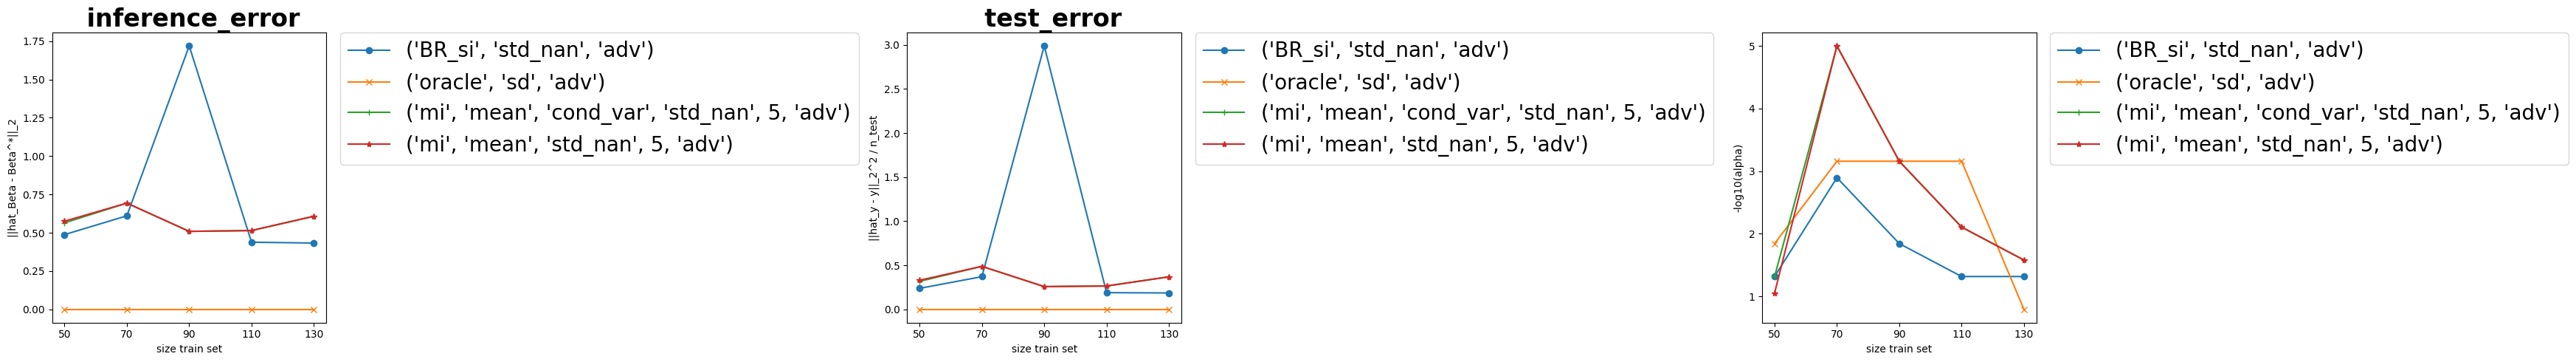

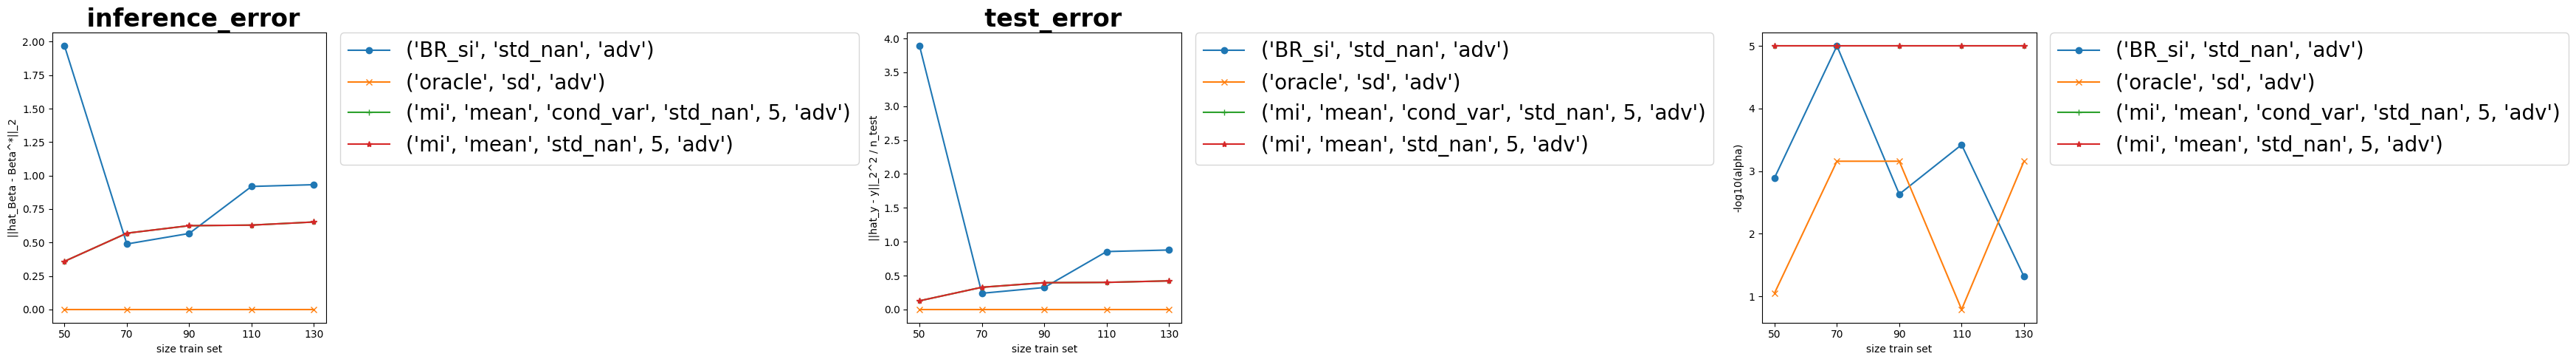

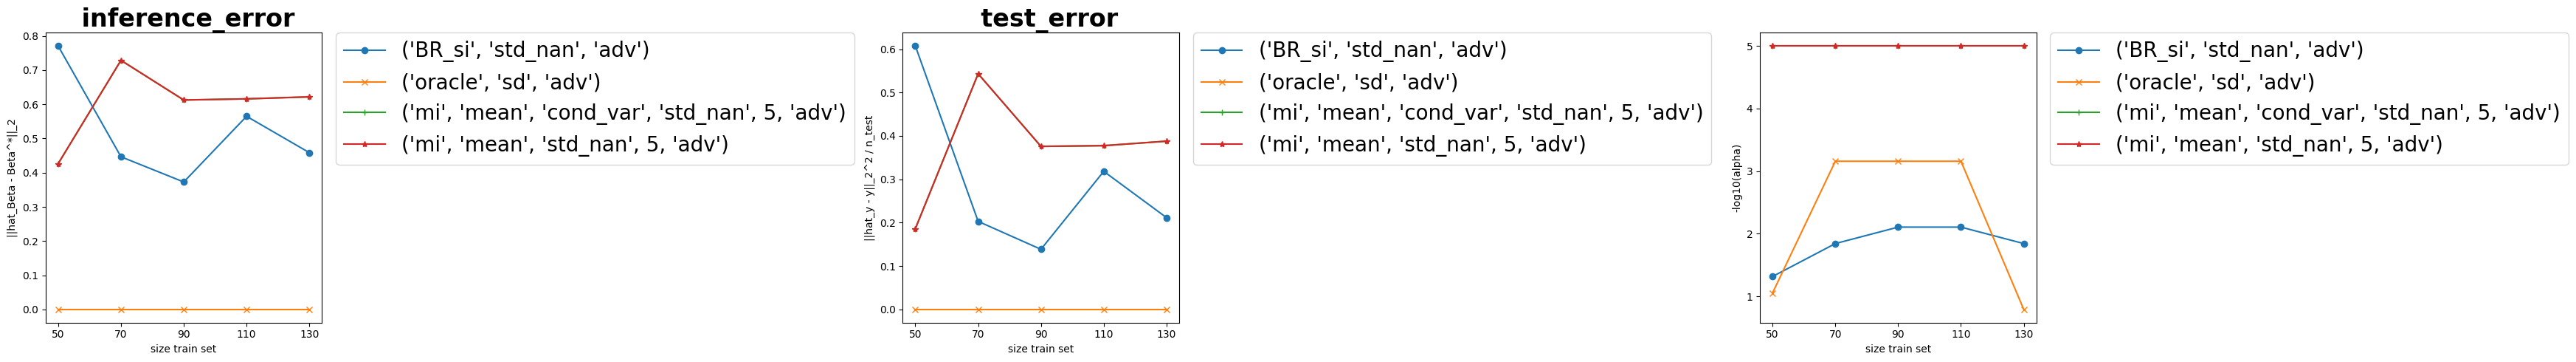

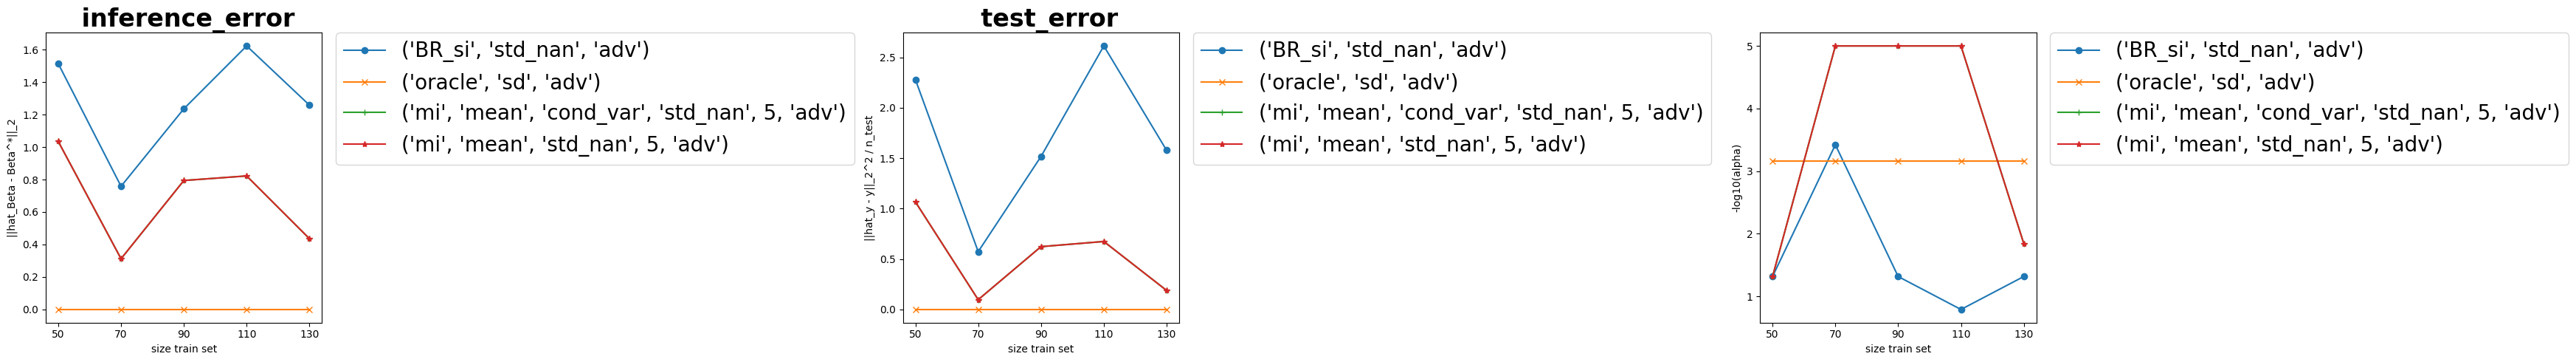

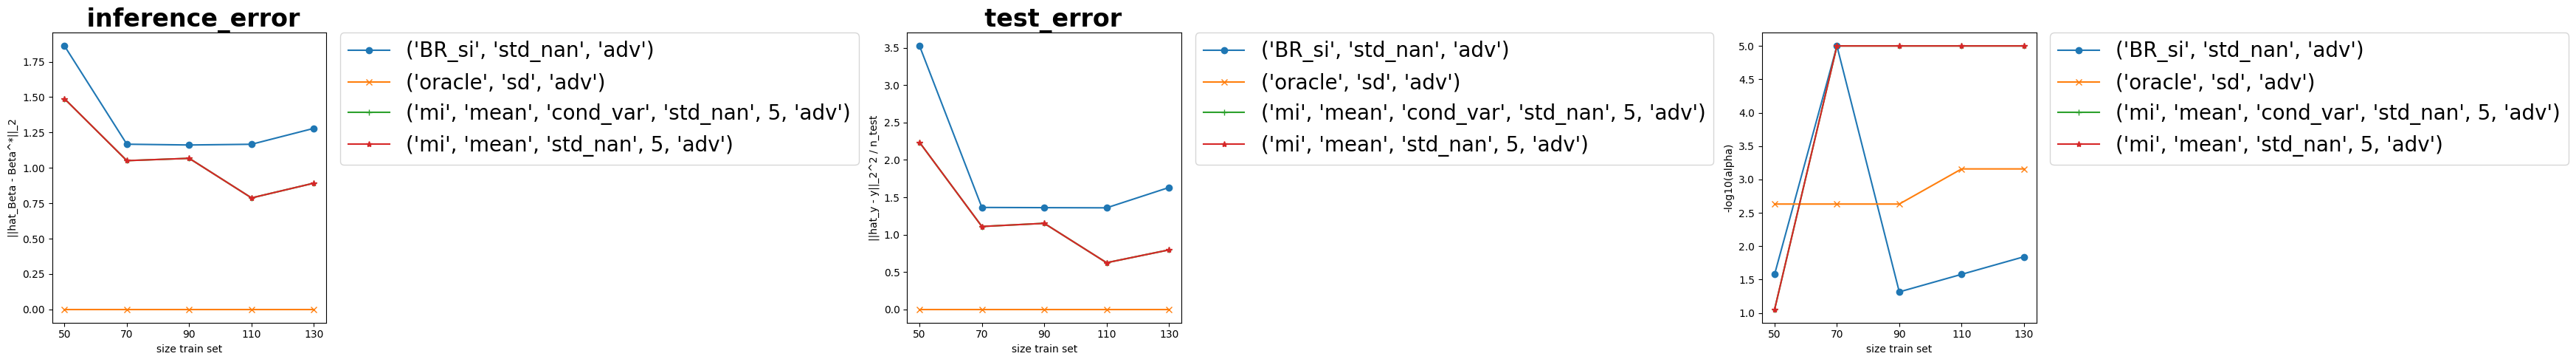

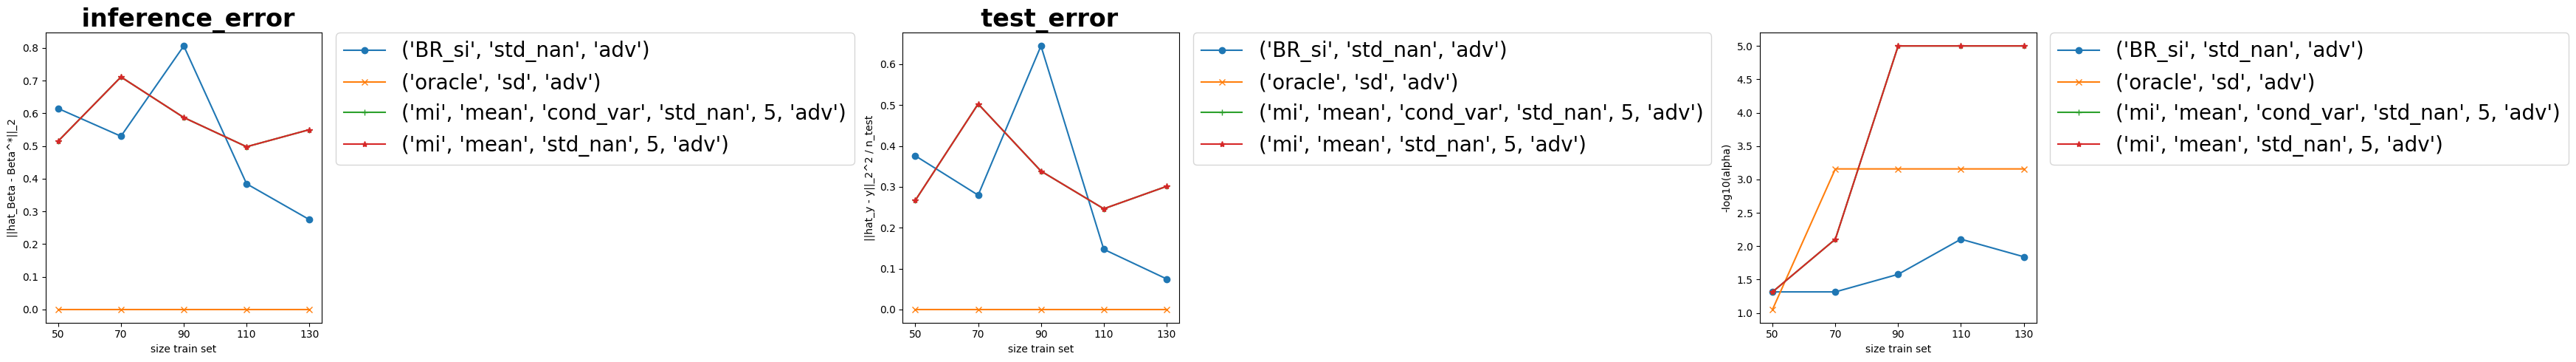

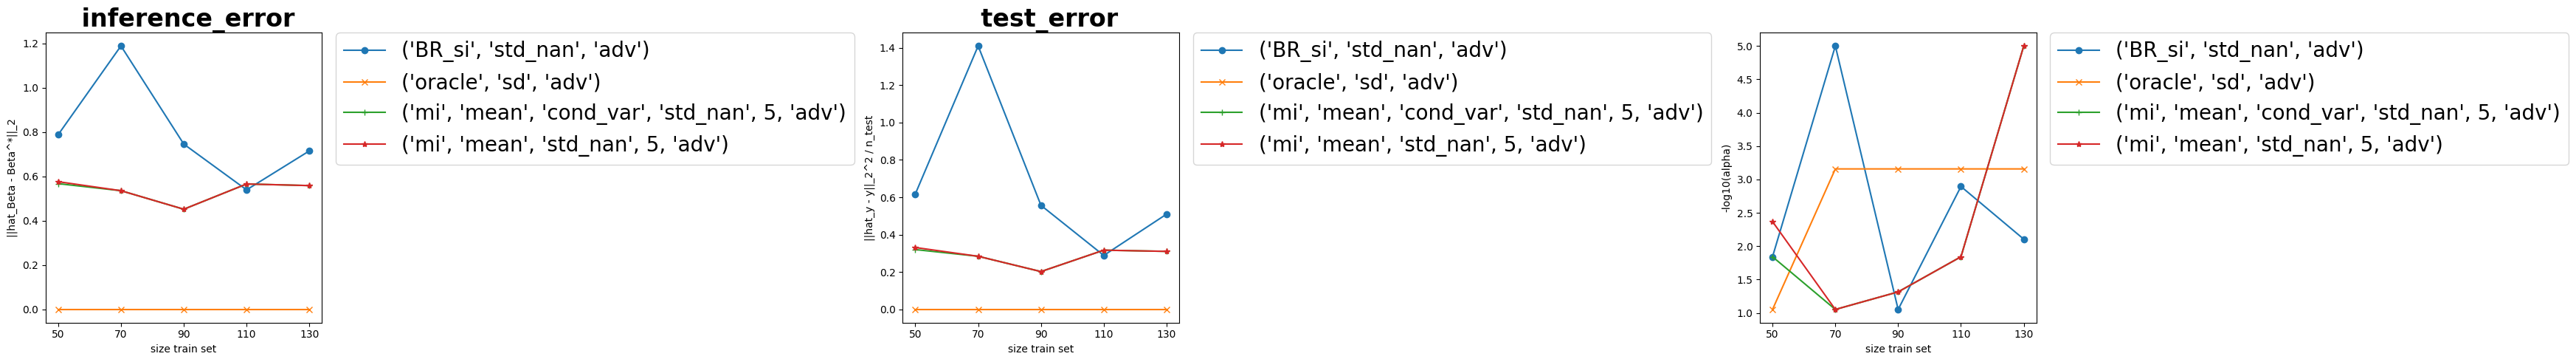

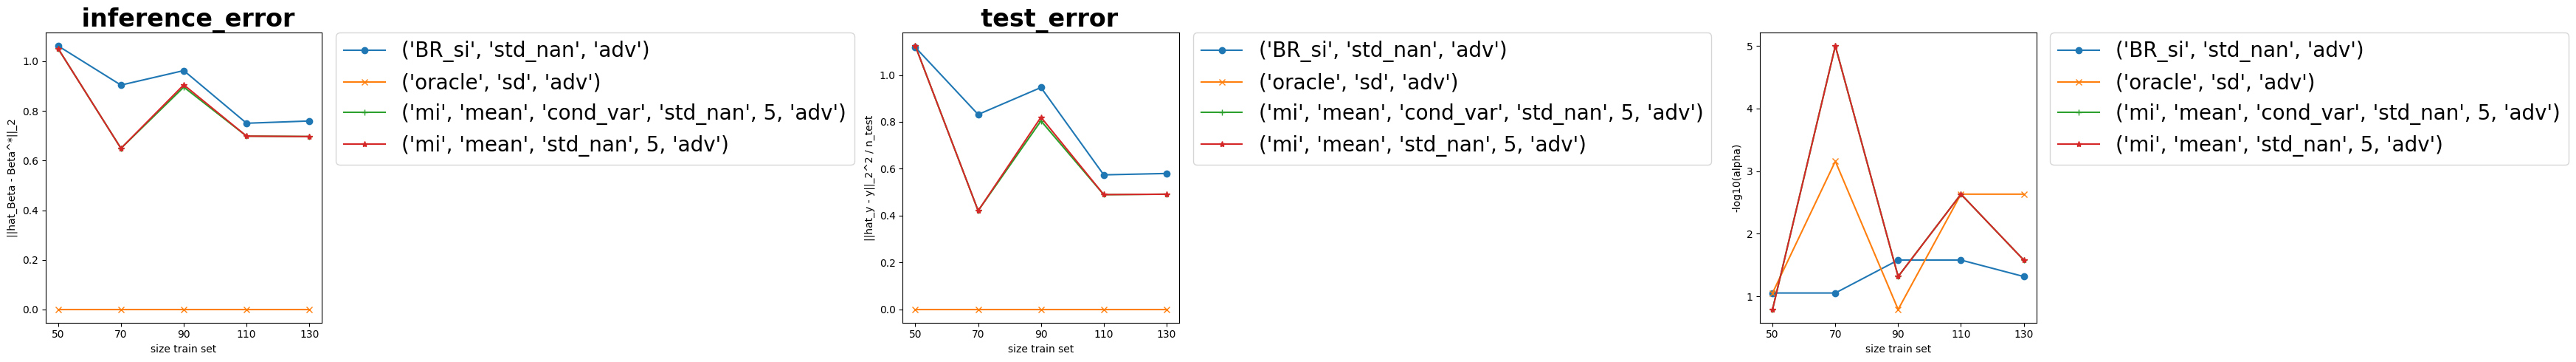

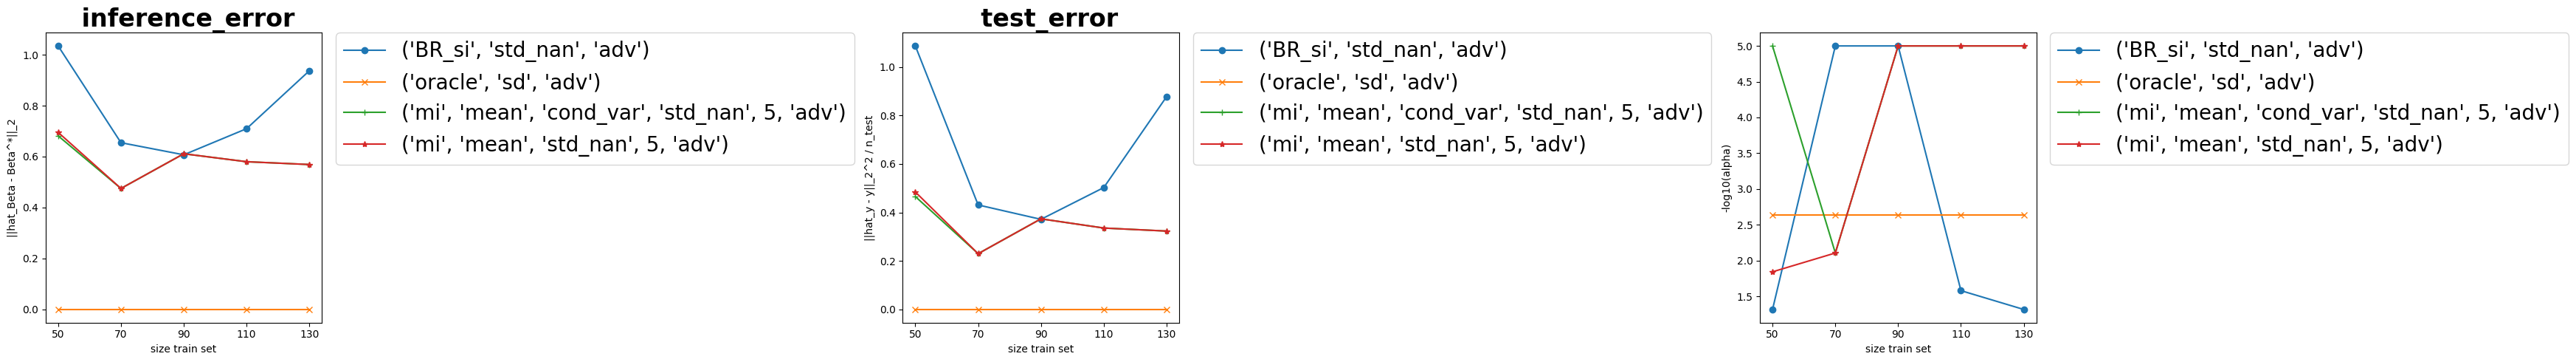

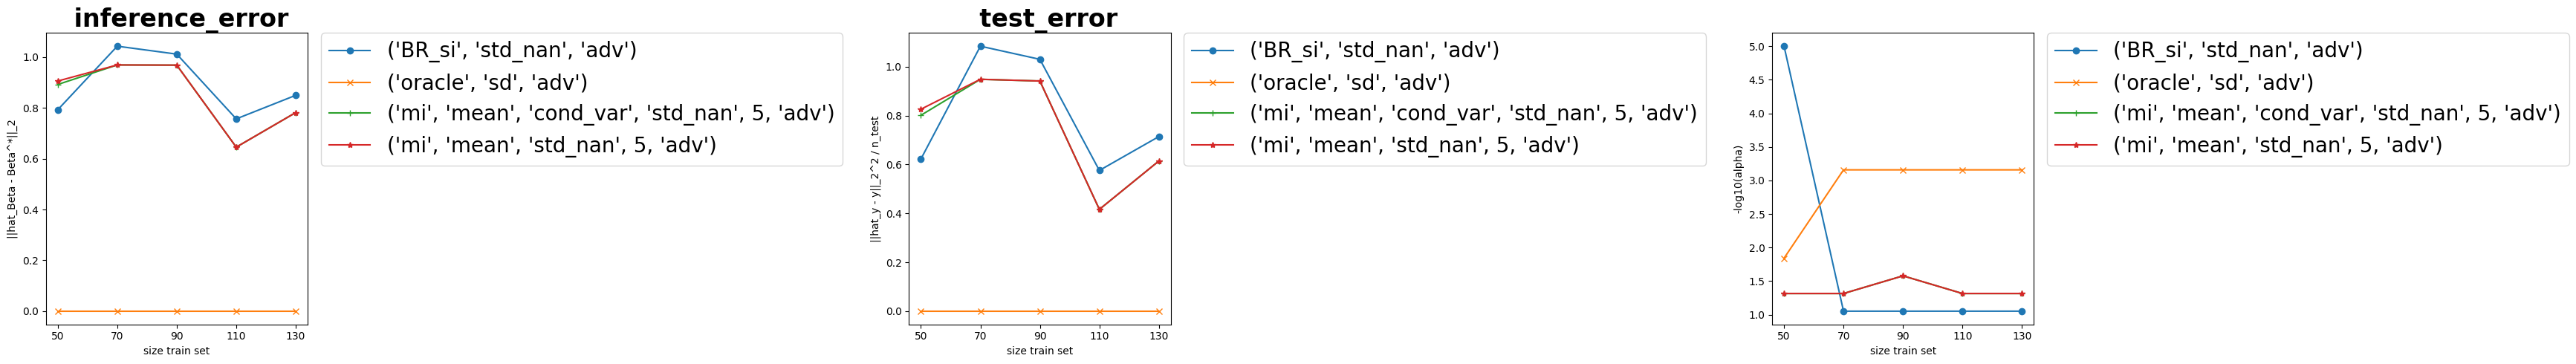

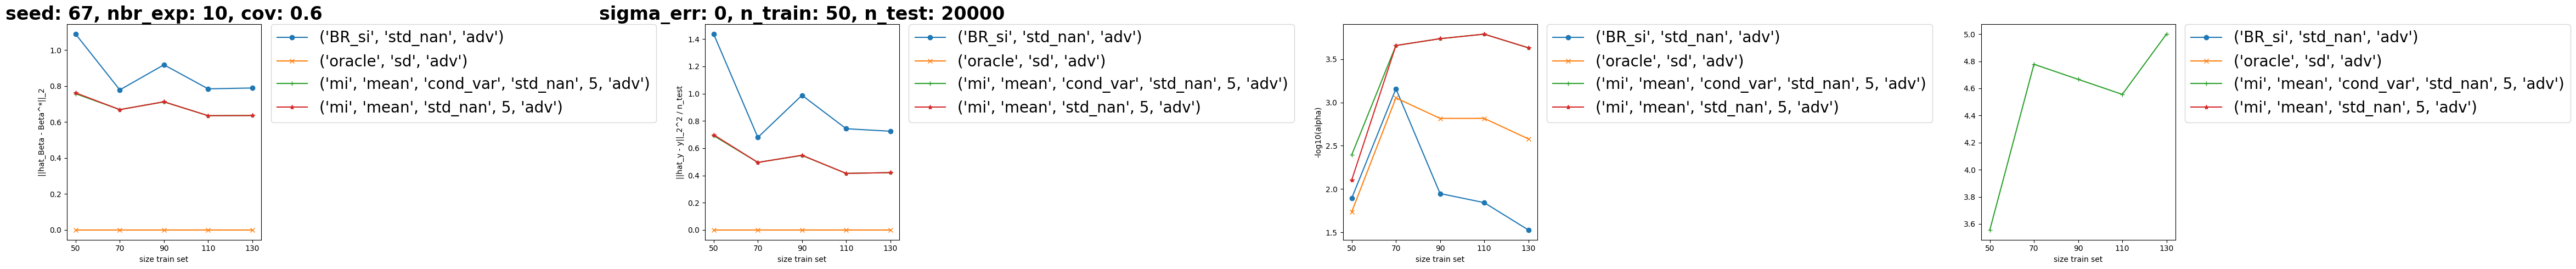

In [17]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
gen = 'fixed'
info_axis = 'train'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6, 0.4/0.5, 0.3/0.4]
n_train = [50, 70, 90, 110, 130]  # check how dataset are generated, there should be some problems with 'fixed'
lenght_vec = len(n_train)
p_seen_both = [0.50, 1, 1, 1, 1, 1, 1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
error_vec =  [0] * length_vec
#p_seen = make_probabilities(p_seen_both)
p_seen = [p_seen_both] * length_vec
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = np.cumprod(p_seen_both)  # p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
cov_var = 0.6
#beta_gt = np.array([-0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4, 5, 6, 7, 8])
#beta_gt = np.array([2, 4, -0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4])
beta_gt = np.random.randn(6)
print(beta_gt)
dim = len(beta_gt)
mean = np.array([0] * dim)
matr = np.random.randn(dim, dim) * 1
cov = matr.T @ matr + np.eye(dim) * 0.5
# np.array([[1, cov_var], [cov_var, 1]])

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': 'Gaussian', 'mean': mean, 'cov': cov},
    beta_gt = beta_gt,
    p_miss = p_seen,
    err_vector = ['Gaussian_on_X', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc['what_to_plot'] = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha_dts']
dicc = dicc | {'generation': gen, 'title_infer_error':' inference_error', 'title_test_error':'  test_error'}
dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg_max': 1,
                             'eps_adv_rad_times_delta_dts': 1e-5, 'eps_adv_rad_times_delta_mis': 1e-5, 'eps_alpha_ridge_reg': 1e-5,
                             'n_a_dts': 20, 'n_a_mis':10, 'n_a_rid': 1}}

for key, value in dicc.items():
  print(key, ": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 5
# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):

list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'adv'},  #, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'},  #, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn':'ridge'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv'}, #, 'multip_dataset': 3, 'multip_missing': 3},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'ridge'}
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv'}
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr}#, 'multip_dataset': 3, 'multip_missing': 3}
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''

nbr_exp = 10
seed = 67
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', n_train: ' + str(n_train[0]) + ', n_test: ' + str(number_test)
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
dicc['what_to_plot'] = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha_dts', 'best_alpha_mis']
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [8]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


[[[3 3]
  [3 2]]

 [[2 2]
  [2 4]]]
[[3 3]
 [3 2]
 [2 2]
 [2 4]]
[[[2 4]
  [2 2]
  [4 4]]]
[[2 4]
 [2 2]
 [4 4]]
[[2 2]
 [3 3]
 [2 2]
 [3 4]
 [4 2]]
[2 2 3 3 2 2 3 4 4 2]
other
[2 2 3 3 2]
[2 2 3 3 2 2 2 3 3 2 2 2 3 3 2]
other mult
[[3 5]
 [5 2]
 [3 7]]
[[3 5]
 [5 2]
 [3 7]
 [3 5]
 [5 2]
 [3 7]
 [3 5]
 [5 2]
 [3 7]]


In [9]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

'\n## random forest imputer\nfrom sklearn.ensemble import RandomForestRegressor\nrf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)\n\nX_rf = single_imputation(X_nan, rf_estimator)\nprint(X_rf.shape)\nsd_rf = np.std(X_rf, axis=0)\nS_inv_rf = np.diag(1 / sd_rf)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std rf\n ", sd_rf)\nfig, ax = plt.subplots(num=\'advtrain_linf_rf\')\nlinfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)\nestimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_rf, ax)\n'

In [10]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

'\n## iterative imputer Bayesian Ridge\n\nfrom sklearn.linear_model import BayesianRidge\nbr_estimator = BayesianRidge()\n\nX_br = single_imputation(X_nan, br_estimator)\nsd_br = np.std(X_br, axis=0)\nS_inv_br = np.diag(1 / sd_br)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std  br\n ", sd_br)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_br\')\nlinfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)\nestimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)\nplot_coefs_l1norm(coefs_advtrain_linf_br, ax)\n'

In [11]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

"\n## mean imputation\nfrom sklearn.impute import SimpleImputer\n\nimp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')\nX_mean = imp_mean.fit_transform(X_nan)\nsd_mean = np.std(X_mean, axis=0)\nprint(sd_mean)\nS_inv_mean = np.diag(1 / sd_mean)\n\nfig, ax = plt.subplots(num='advtrain_linf_mean')\nlinfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)\nestimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_mean, ax)\n"

In [12]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

'\n# imputation elliptic\n\nmu = np.nanmean(X_nan, axis=0)\nprint("means ", mu)\ndelta = np.mean(masks) # parameter missingness\nprint("delta ", delta)\nX_0 = np.nan_to_num(X_nan)\nprint("nbr obs", X_0.shape[0])\nS_ellp =  X_0.T @ X_0 / X_0.shape[0]\nS_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp\nprint("eig cov ", np.linalg.eigvalsh(S_ellp))\nX_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)\n#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance\nsd_inv_ellp = np.std(X_ellp, axis=0)\nprint("sd ellp", sd_inv_ellp)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_ellp\')\nlinfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)\nestimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)\n'

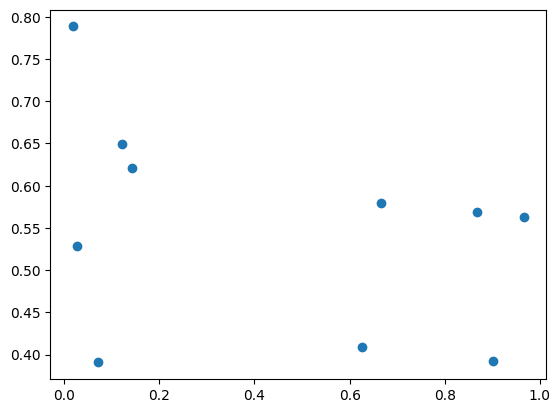

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

#add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [14]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


test generate_X started
(1000, 2)
test generate passed syccessfully

test preparation dataset started
X_train 
 [[0.04882641 0.60856921 0.48697528 0.9589182 ]
 [0.08366181 0.87320568 0.53055065 0.14100974]
 [0.72015882 0.1100106  0.46123989 0.52810888]]
mask, 0 seen, 1 missing 
  [[1 1 1 1]
 [1 0 1 1]
 [1 0 1 0]]
X_masked 
 [[0.         0.         0.         0.        ]
 [0.         0.87320568 0.         0.        ]
 [0.         0.1100106  0.         0.52810888]]
X_nan_train 
 [[       nan        nan        nan        nan]
 [       nan 0.87320568        nan        nan]
 [       nan 0.1100106         nan 0.52810888]]
X_br_train
  [[0.49160814 0.52810888]
 [0.87320568 0.52810888]
 [0.1100106  0.52810888]]
what happens if we run single_imputation of full dataset
X_br_full
  [[0.04882641 0.60856921 0.48697528 0.9589182 ]
 [0.08366181 0.87320568 0.53055065 0.14100974]
 [0.72015882 0.1100106  0.46123989 0.52810888]]
test preparation dataset ended successfully

 test list_wise delection start

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0 2]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [15]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




[3]
scores:   [5.38912547e+08 5.39186238e+08 5.39602864e+08 2.12990000e+02
 5.38905603e+08 5.39005102e+08 5.39755881e+08 5.40447503e+08
 5.38746407e+08 5.39169822e+08 5.38682415e+08 5.39975633e+08
 5.39186056e+08 5.39532648e+08 5.39843123e+08 5.38277772e+08
 5.38711888e+08 5.38923404e+08 5.38102460e+08 5.39582688e+08]
best coeff  [3 1 2 4 2]
best score  212.99
test best predictor passed


n:   442 , d:  10


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

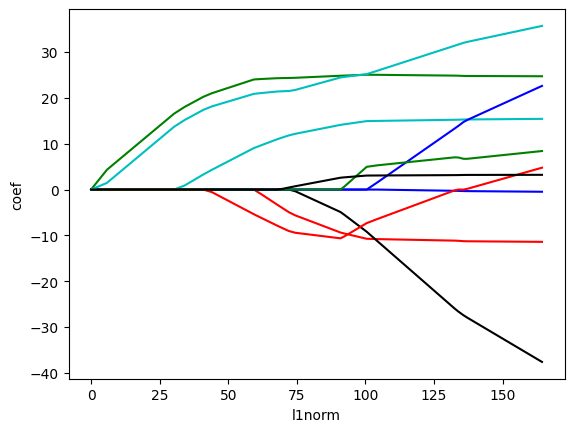

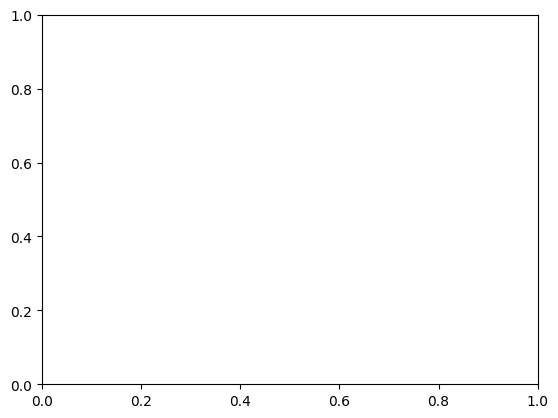

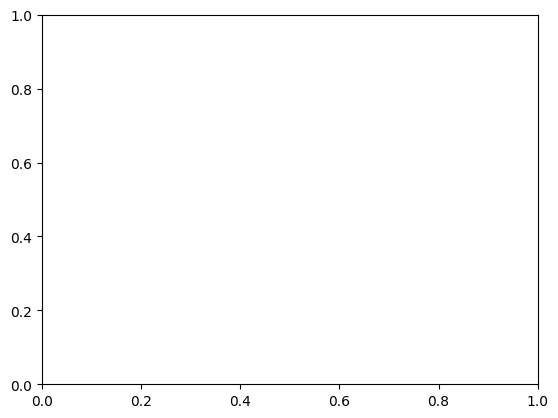

In [16]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]



In [ ]:
import numpy as np

XX = np.random.randint(1, 7, (2, 3, 3))
print(XX)
XXX = np.tile(XX, (2, 1, 1))
print(XXX)

print(np.zeros(2))

y_o = np.array([1, 2])
y_oo = np.tile(y_o, 3)
print(y_oo)


In [ ]:
import numpy as np
def generate_masks_binomial_general(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks


#mm = np.random.binomial(1, [[0.2, 0.2, 0.2], [0.8, 0.8, 0.8]], (2, 3, 3))
#print(mm)
cc = np.array([np.random.binomial(1, x, (4, 4)) for x in [0.2, 0.2, 0.2]])
print(cc)
s_cc = np.cumsum(cc, axis=0)
print(s_cc)
s_cc[s_cc>1] = 1
print(s_cc)

s_v = np.random.randint(1, 4, (3, 4))
print(s_v)
s_vv = s_v[:, None, :] * np.eye(4)
print(s_vv)









In [ ]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import ridge_regression

X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)
np.random.seed(4)
alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False, random_state=0)
for a in alphas:
  #coef, intercept = estim(X, y, a)
  coef = estim(X, y, a)
  print("coef : ", coef)
  #print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  #print("coef : ", coef)
  #print("intercpt ", intercept)


lg = np.random.logistic(loc=0.0, scale=1.0, size=(4, 3))
print("log res ", lg)

